# **NEW YORK TLC TRIP ANALYSIS**

# Introduction

Taxis are one of the main ways people commute in New York City, particularly for trips where subways or buses are less convenient or accessible. The New York City Taxi and Limousine Commission (TLC) trip dataset provides a comprehensive collection of detailed records about taxi rides throughout the city. The TLC, as the regulatory body overseeing taxis and ride services in NYC, ensures that this data is systematically collected and maintained. Each record includes information such as pick-up and drop-off locations, trip distance, duration, fare amount, and payment type. Analyzing this dataset is valuable because taxis represent a crucial component of New York City’s transportation network, helping researchers and policymakers understand commuting behavior, travel demand patterns, geographic mobility, and operational variations across vendors and zones.

## Data

Datasets required for this analysis:

*   New York City TLC Trip Record – Contains detailed trip-level data including
timestamps, pickup and dropoff locations, passenger count, trip distance, fare, payment type, and additional charges.
*   Taxi Zone Lookup Table – Provides descriptive information about NYC taxi zones corresponding to the PULocationID and DOLocationID in the trip record. (Source: [Taxi Zone Dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
)






# Stakeholder

The dataset analysis result will be highly valuable for the New York City Taxi and Limousine Commission (TLC), as they are responsible for regulating taxis, setting policies such as congestion surcharges, and overseeing vendor performance.

# Problems and Objectives



1. Trip Patterns – Identify peak and low demand hours, days, and day periods to optimize taxi supply and distribution.
2. Area Distribution – Identify key pickup and drop-off areas to allocate taxis more effectively based on demand.
3. Pricing Patterns – Analyze fare amount trends per hour to optimize pricing and manage demand effectively, with tipping behavior included as optional insight for drivers or platforms collaborating with NYC TLC.
4. Congestion Surcharge – Determine when and where congestion surcharges should be applied to better manage traffic and passenger demand.
5. Vendor Performance – Evaluate vendor performance to identify the most reliable operators, ensuring better service quality for commuters.

# Import Library & Data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("Paired")  # contoh: Set2
sns.set_palette(color)
import geopandas as gpd

# Bisa juga set style/theme untuk konsistensi
sns.set_theme(style="whitegrid")

from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 30)

In [ ]:
# NYC TLC Trip Record
df1 = pd.read_csv(r"NYC TLC Trip Record.csv")
df1.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


In [ ]:
# Taxi Zone Lookup
df2 = pd.read_csv(r"taxi_zone_lookup.csv")
df2.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


# Data Understanding

In [ ]:
# Merge the Taxi Zone Lookup Table with the NYC TLC Trip data to obtain information about the NYC areas.

df= pd.merge(
    df1,
    df2.add_prefix("PU_"),
    left_on="PULocationID",
    right_on="PU_LocationID",
    how="left"
).drop(columns=["PU_LocationID"])

df = pd.merge(
    df,
    df2.add_prefix("DO_"),
    left_on="DOLocationID",
    right_on="DO_LocationID",
    how="left"
).drop(columns=["DO_LocationID"])

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75,Manhattan,Morningside Heights,Boro Zone,Manhattan,Lincoln Square West,Yellow Zone
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00,Manhattan,Bloomingdale,Yellow Zone,Manhattan,Central Park,Yellow Zone
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00,Queens,Steinway,Boro Zone,Queens,Old Astoria,Boro Zone
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,Upper West Side North,Yellow Zone
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,East Harlem North,Boro Zone


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [ ]:
display(df.describe(), df.describe(include='object'))

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,0.0,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,NaN,0.951625,21.789377,1.373613,1.021933,0.726748
std,0.343820,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,NaN,0.196875,15.457115,0.508039,0.146465,1.212836
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,NaN,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,NaN,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,NaN,1.000000,491.000000,5.000000,2.000000,2.750000


,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone
count,68211,68211,63887,68145,68076,68010,67969,67785,67543
unique,66575,66519,2,7,224,4,7,247,4
top,2023-01-09 09:08:00,2023-01-09 00:00:00,N,Manhattan,East Harlem North,Boro Zone,Manhattan,East Harlem South,Boro Zone
freq,4,6,63579,39436,13257,64013,39617,3524,43605


In [ ]:
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,VendorID,2,"[2, 1]"
1,lpep_pickup_datetime,66575,"[2023-01-01 00:26:10, 2023-01-01 00:51:03, 2023-01-01 00:35:12, 2023-01-01 00:13:14, 2023-01-01 00:33:04, 2023-01-01 00:53:31, 2023-01-01 00:09:14, 2023-01-01 00:11:58, 2023-01-01 00:41:29, 2023-01-01 00:50:32, 2023-01-01 00:16:12, 2023-01-01 00:08:43, 2023-01-01 00:26:32, 2023-01-01 00:18:35, 2023-01-01 00:39:32, 2023-01-01 00:49:34, 2023-01-01 00:10:45, 2023-01-01 00:35:11, 2023-01-01 00:31:06, 2023-01-01 00:14:37, 2023-01-01 00:26:21, 2023-01-01 00:41:56, 2023-01-01 00:32:02, 2023-01-01 00:55:13, 2023-01-01 00:01:31, 2023-01-01 00:22:31, 2023-01-01 00:57:28, 2023-01-01 00:35:21, 2023-01-01 00:52:52, 2023-01-01 00:32:56, 2023-01-01 00:24:01, 2023-01-01 00:46:48, 2023-01-01 00:40:58, 2023-01-01 00:20:23, 2023-01-01 01:49:24, 2023-01-01 00:41:53, 2023-01-01 00:56:26, 2023-01-01 00:33:10, 2023-01-01 00:58:28, 2023-01-01 00:42:49, 2023-01-01 00:48:21, 2023-01-01 00:08:05, 2023-01-01 00:13:47, 2023-01-01 00:16:10, 2023-01-01 00:04:25, 2023-01-01 00:33:38, 2023-01-01 00:46:08, 2023-01-01 01:00:08, 2023-01-01 00:28:04, 2023-01-01 00:23:04, 2023-01-01 00:34:07, 2023-01-01 00:52:03, 2023-01-01 00:25:31, 2023-01-01 00:53:09, 2023-01-01 00:42:37, 2023-01-01 00:39:52, 2023-01-01 00:15:32, 2023-01-01 00:06:48, 2023-01-01 00:57:15, 2023-01-01 00:14:13, 2023-01-01 00:52:48, 2023-01-01 00:34:13, 2023-01-01 00:44:41, 2023-01-01 00:11:12, 2023-01-01 01:44:43, 2023-01-01 01:04:44, 2023-01-01 01:48:11, 2023-01-01 01:11:39, 2023-01-01 01:54:25, 2023-01-01 01:59:10, 2023-01-01 01:22:35, 2023-01-01 01:37:10, 2023-01-01 01:46:22, 2023-01-01 01:59:48, 2023-01-01 01:09:49, 2023-01-01 01:23:35, 2023-01-01 01:53:20, 2023-01-01 01:32:14, 2023-01-01 01:01:05, 2023-01-01 01:34:41, 2023-01-01 01:52:08, 2023-01-01 01:49:28, 2023-01-01 01:03:59, 2023-01-01 01:13:11, 2023-01-01 01:40:06, 2023-01-01 01:33:50, 2023-01-01 01:45:19, 2023-01-01 01:51:29, 2023-01-01 01:34:07, 2023-01-01 01:10:08, 2023-01-01 01:32:17, 2023-01-01 01:48:28, 2023-01-01 01:30:43, 2023-01-01 01:51:10, 2023-01-01 01:09:36, 2023-01-01 01:19:54, 2023-01-01 01:31:10, 2023-01-01 01:42:30, 2023-01-01 00:57:51, 2023-01-01 01:27:36, ...]"
2,lpep_dropoff_datetime,66519,"[2023-01-01 00:37:11, 2023-01-01 00:57:49, 2023-01-01 00:41:32, 2023-01-01 00:19:03, 2023-01-01 00:39:02, 2023-01-01 01:11:04, 2023-01-01 00:26:39, 2023-01-01 00:24:55, 2023-01-01 00:46:26, 2023-01-01 01:13:42, 2023-01-01 00:41:43, 2023-01-01 00:17:08, 2023-01-01 00:45:31, 2023-01-01 00:30:09, 2023-01-01 01:18:06, 2023-01-01 01:08:23, 2023-01-01 00:19:37, 2023-01-01 01:17:35, 2023-01-01 00:42:23, 2023-01-01 00:21:50, 2023-01-01 00:30:26, 2023-01-01 00:46:06, 2023-01-01 00:41:25, 2023-01-01 00:59:47, 2023-01-01 00:16:02, 2023-01-01 00:39:24, 2023-01-01 01:09:31, 2023-01-01 00:53:49, 2023-01-01 01:00:53, 2023-01-01 00:42:53, 2023-01-01 00:32:05, 2023-01-01 01:08:17, 2023-01-01 01:04:32, 2023-01-01 00:24:32, 2023-01-01 01:57:51, 2023-01-01 00:41:58, 2023-01-01 01:14:41, 2023-01-01 00:43:08, 2023-01-01 01:14:46, 2023-01-01 00:51:53, 2023-01-01 01:23:50, 2023-01-01 00:13:26, 2023-01-01 00:25:57, 2023-01-01 00:54:55, 2023-01-01 00:17:50, 2023-01-01 00:38:51, 2023-01-01 00:59:10, 2023-01-01 01:05:46, 2023-01-01 00:43:45, 2023-01-01 23:18:32, 2023-01-01 00:50:01, 2023-01-01 00:57:56, 2023-01-01 00:38:40, 2023-01-01 01:13:35, 2023-01-01 00:47:15, 2023-01-01 00:48:54, 2023-01-01 00:23:03, 2023-01-01 01:08:47, 2023-01-01 01:00:15, 2023-01-01 00:25:43, 2023-01-01 01:21:19, 2023-01-01 00:43:57, 2023-01-01 00:48:26, 2023-01-01 00:38:12, 2023-01-01 01:57:31, 2023-01-01 01:11:23, 2023-01-01 02:05:51, 2023-01-01 01:41:21, 2023-01-01 02:05:19, 2023-01-01 02:11:36, 2023-01-01 01:25:11, 2023-01-01 01:41:30, 2023-01-01 02:04:14, 2023-01-01 02:05:29, 2023-01-01 01:17:55, 2023-01-01 01:53:43, 2023-01-01 02:27:01, 2023-01-01 01:43:55, 2023-01-01 01:13:02, 2023-01-01 02:00:06, 2023-01-01 02:00:57, 2023-01-01 02:13:18, 2023-01-01 01:07:17, 2023-01-01 01:26:01, 2

# Data Cleansing

Before modifying the dataset, it needs to be duplicated.

In [ ]:
df_raw = df.copy()

## Data Type

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [ ]:
# Convert datetime columns
df['lpep_pickup_datetime']=pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime']=pd.to_datetime(df['lpep_dropoff_datetime'])

# Convert numeric columns
df['passenger_count'] = df['passenger_count'].astype("Int64")

# Convert categorical columns
df['VendorID'] = df['VendorID'].astype("category")
df['RatecodeID'] = df['RatecodeID'].astype("category")
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype("category")
df['payment_type'] = df['payment_type'].astype("category")
df['trip_type'] = df['trip_type'].astype("category")
df['congestion_surcharge'] = df['congestion_surcharge'].astype("category")

Using Int64 for passenger_count allows for missing values (NA) without breaking analysis.

## Drop Unused & Add New Column

### Drop Columns

In [ ]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'PU_Borough', 'PU_Zone', 'PU_service_zone', 'DO_Borough', 'DO_Zone',
       'DO_service_zone'],
      dtype='object')

In [ ]:
df = df.drop(columns=['ehail_fee', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge'], axis=1)

The columns 'ehail_fee', 'extra', 'mta_tax', 'tolls_amount', and 'improvement_surcharge' are not relevant for this analysis, so they are dropped from the dataset.

In [ ]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'PU_Borough', 'PU_Zone', 'PU_service_zone', 'DO_Borough', 'DO_Zone',
       'DO_service_zone'],
      dtype='object')

### Add New Columns

Create new columns to display trip duration, hour, as well as day period, day of the week, and year, for easier analysis.

In [ ]:
# trip duration (min)
df['trip_duration_min'] = (
    (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime'])
    .dt.total_seconds() / 60
)

In [ ]:
# Hour

df['PU_Hour'] = df['lpep_pickup_datetime'].dt.hour
df['DO_Hour'] = df['lpep_dropoff_datetime'].dt.hour

# Day Periods
def day_periods(hour):
    if hour in range(5,12):
        return 'Morning'
    elif hour in range(12,17):
        return 'Afternoon'
    elif hour in range(17,22):
        return 'Evening'
    else:
        return 'Night'

df['PU_dayperiod'] = df['PU_Hour'].apply(day_periods)
df['DO_dayperiod'] = df['DO_Hour'].apply(day_periods)

# Day Name
df['PU_dayname'] = df['lpep_pickup_datetime'].dt.day_name()
df['DO_dayname'] = df['lpep_dropoff_datetime'].dt.day_name()

# Year
df['PU_Year'] = df['lpep_pickup_datetime'].dt.year
df['DO_Year'] = df['lpep_dropoff_datetime'].dt.year

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1,2.58,14.9,4.03,24.18,1.0,1.0,2.75,Manhattan,Morningside Heights,Boro Zone,Manhattan,Lincoln Square West,Yellow Zone,11.016667,0,0,Night,Night,Sunday,Sunday,2023,2023
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1,1.81,10.7,2.64,15.84,1.0,1.0,0.00,Manhattan,Bloomingdale,Yellow Zone,Manhattan,Central Park,Yellow Zone,6.766667,0,0,Night,Night,Sunday,Sunday,2023,2023
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1,0.00,7.2,1.94,11.64,1.0,1.0,0.00,Queens,Steinway,Boro Zone,Queens,Old Astoria,Boro Zone,6.333333,0,0,Night,Night,Sunday,Sunday,2023,2023
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1,1.30,6.5,1.70,10.20,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,Upper West Side North,Yellow Zone,5.816667,0,0,Night,Night,Sunday,Sunday,2023,2023
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1,1.10,6.0,0.00,8.00,1.0,1.0,0.00,Manhattan,Central Harlem,Boro Zone,Manhattan,East Harlem North,Boro Zone,5.966667,0,0,Night,Night,Sunday,Sunday,2023,2023


## Missing Value

In [ ]:
df.isnull().sum()

,0
VendorID,0
lpep_pickup_datetime,0
lpep_dropoff_datetime,0
store_and_fwd_flag,4324
RatecodeID,4324
PULocationID,0
DOLocationID,0
passenger_count,4324
trip_distance,0
fare_amount,0


In [ ]:
pd.DataFrame({
    'null_value(%)': (df.isna().sum() / len(df) * 100).round(2)
}).round(2)

,null_value(%)
VendorID,0.00
lpep_pickup_datetime,0.00
lpep_dropoff_datetime,0.00
store_and_fwd_flag,6.34
RatecodeID,6.34
PULocationID,0.00
DOLocationID,0.00
passenger_count,6.34
trip_distance,0.00
fare_amount,0.00


- The number of missing values in these columns is relatively small compared to the overall dataset.
- The number of missing values in store_and_fwd_flag, RatecodeID, passenger_count, payment_type, and congestion_surcharge is similar and not significantly different from that in trip_type.

### store_and_fwd_flag

In [ ]:
df['store_and_fwd_flag'].value_counts()

,count
store_and_fwd_flag,
N,63579
Y,308


Impute missing values in store_and_fwd_flag using the mode.

In [ ]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0])

In [ ]:
df['store_and_fwd_flag'].isnull().sum()

np.int64(0)

### RatecodeId

In [ ]:
df['RatecodeID'].value_counts()

,count
RatecodeID,
1.0,62103
5.0,1529
2.0,158
4.0,57
3.0,30
99.0,10


RateCodeID is supposed to range from 1 to 6, but there are 10 records with a value of 99. These are likely errors or incorrect inputs, so it is better to drop them.

In [ ]:
df = df.drop(df[df['RatecodeID'] == 99].index)

In [ ]:
df['RatecodeID'].isnull().sum()

np.int64(4324)

In [ ]:
df[df['RatecodeID'].isnull()]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
63887,2,2023-01-01 00:28:00,2023-01-01 00:54:00,N,NaN,7,17,<NA>,9.33,36.03,7.41,44.44,NaN,NaN,NaN,Queens,Astoria,Boro Zone,Brooklyn,Bedford,Boro Zone,26.0,0,0,Night,Night,Sunday,Sunday,2023,2023
63888,2,2023-01-01 00:39:00,2023-01-01 00:52:00,N,NaN,37,37,<NA>,2.67,14.55,3.11,18.66,NaN,NaN,NaN,Brooklyn,Bushwick South,Boro Zone,Brooklyn,Bushwick South,Boro Zone,13.0,0,0,Night,Night,Sunday,Sunday,2023,2023
63889,2,2023-01-01 00:58:00,2023-01-01 01:21:00,N,NaN,80,7,<NA>,7.39,32.13,6.63,39.76,NaN,NaN,NaN,Brooklyn,East Williamsburg,Boro Zone,Queens,Astoria,Boro Zone,23.0,0,1,Night,Night,Sunday,Sunday,2023,2023
63890,2,2023-01-01 00:35:00,2023-01-01 00:55:00,N,NaN,169,42,<NA>,4.04,17.85,0.00,18.85,NaN,NaN,NaN,Bronx,Mount Hope,Boro Zone,Manhattan,Central Harlem North,Boro Zone,20.0,0,0,Night,Night,Sunday,Sunday,2023,2023
63891,2,2023-01-01 00:45:00,2023-01-01 00:55:00,N,NaN,42,262,<NA>,3.86,19.67,4.68,28.10,NaN,NaN,NaN,Manhattan,Central Harlem North,Boro Zone,Manhattan,Yorkville East,Yellow Zone,10.0,0,0,Night,Night,Sunday,Sunday,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,NaN,49,62,<NA>,4070.82,15.70,0.00,16.70,NaN,NaN,NaN,Brooklyn,Clinton Hill,Boro Zone,Brooklyn,Crown Heights South,Boro Zone,13.0,22,22,Night,Night,Tuesday,Tuesday,2023,2023
68207,2,2023-01-31 22:40:00,2023-01-31 22:48:00,N,NaN,10,205,<NA>,2.14,4.41,0.00,5.41,NaN,NaN,NaN,Queens,Baisley Park,Boro Zone,Queens,Saint Albans,Boro Zone,8.0,22,22,Night,Night,Tuesday,Tuesday,2023,2023
68208,2,2023-01-31 23:46:00,2023-02-01 00:02:00,N,NaN,66,37,<NA>,3.44,16.53,3.51,21.04,NaN,NaN,NaN,Brooklyn,DUMBO/Vinegar Hill,Boro Zone,Brooklyn,Bushwick South,Boro Zone,16.0,23,0,Night,Night,Tuesday,Wednesday,2023,2023
68209,2,2023-01-31 23:01:00,2023-01-31 23:19:00,N,NaN,225,189,<NA>,3.03,14.98,3.20,19.18,NaN,NaN,NaN,Brooklyn,Stuyvesant Heights,Boro Zone,Brooklyn,Prospect Heights,Boro Zone,18.0,23,23,Night,Night,Tuesday,Tuesday,2023,2023


In [ ]:
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode()[0])

Impute missing values in RatecodeID using the mode.

### Passanger Count

In [ ]:
df['passenger_count'].value_counts()

,count
passenger_count,
1,54289
2,5096
5,1772
6,1054
3,958
4,364
0,336
7,4
9,2


In [ ]:
from scipy.stats import shapiro

stat, pvalue =shapiro(df['passenger_count'])
alpha = 0.05

if pvalue > alpha:
    print(f'pvalue: {pvalue}. pvalue > {alpha}, Fail to reject H0, we can assume that the data is normally distributed.')
else:
    print(f'pvalue: {pvalue}. pvalue < {alpha}, Reject H0, we can assume that the data is not normally distributed.')

pvalue: nan. pvalue < 0.05, Reject H0, we can assume that the data is not normally distributed.


Based on the Shapiro-Wilk normality test, the passenger_count column is not normally distributed. Therefore, missing values are imputed using the median.

In [ ]:
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].median())

In [ ]:
df['passenger_count'].isnull().sum()

np.int64(0)

### Payment Type

In [ ]:
df['payment_type'].value_counts()

,count
payment_type,
1.0,40676
2.0,22632
3.0,472
4.0,95
5.0,2


In [ ]:
df[df['payment_type'] == 5]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
2289,1,2023-01-02 17:07:45,2023-01-02 17:26:42,N,1.0,73,82,1,0.0,25.0,0.0,25.0,5.0,1.0,0.0,Queens,East Flushing,Boro Zone,Queens,Elmhurst,Boro Zone,18.95,17,17,Evening,Evening,Monday,Monday,2023,2023
14210,1,2023-01-08 12:10:42,2023-01-08 12:10:45,N,1.0,39,39,1,0.0,3.0,0.0,4.5,5.0,1.0,0.0,Brooklyn,Canarsie,Boro Zone,Brooklyn,Canarsie,Boro Zone,0.05,12,12,Afternoon,Afternoon,Sunday,Sunday,2023,2023


The payment_type column should range from 1 to 6, where 6 represents a voided trip. However, there are two records with a payment_type of 5 (Unknown) and a trip_distance of 0 miles but a non-zero total_amount. This suggests these trips were likely canceled or erroneous. According to the NYC TLC data dictionary, a payment_type of 6 signifies a voided trip, which aligns with the nature of these records. Therefore, it is appropriate to reassign these records to payment_type = 6 (Voided trip)

In [ ]:
df['payment_type'] =  df['payment_type'].replace({5 :6})

In [ ]:
df[(df['total_amount'] == 0) & (df['trip_distance'] == 0)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
1581,2,2023-01-02 10:29:51,2023-01-02 10:30:34,N,1.0,264,264,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Unknown,NaN,NaN,Unknown,NaN,NaN,0.716667,10,10,Morning,Morning,Monday,Monday,2023,2023
2130,2,2023-01-02 15:46:00,2023-01-03 15:45:15,N,1.0,193,193,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,1439.250000,15,15,Afternoon,Afternoon,Monday,Tuesday,2023,2023
2793,1,2023-01-03 03:50:19,2023-01-03 03:50:19,Y,5.0,129,264,3,0.0,0.0,0.0,0.0,2.0,1.0,0.0,Queens,Jackson Heights,Boro Zone,Unknown,NaN,NaN,0.000000,3,3,Night,Night,Tuesday,Tuesday,2023,2023
3557,2,2023-01-03 12:39:11,2023-01-03 12:39:19,N,1.0,264,264,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Unknown,NaN,NaN,Unknown,NaN,NaN,0.133333,12,12,Afternoon,Afternoon,Tuesday,Tuesday,2023,2023
3674,2,2023-01-03 13:28:25,2023-01-03 13:28:30,N,1.0,193,193,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.083333,13,13,Afternoon,Afternoon,Tuesday,Tuesday,2023,2023
3962,2,2023-01-03 15:21:44,2023-01-03 15:22:17,N,1.0,193,193,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.550000,15,15,Afternoon,Afternoon,Tuesday,Tuesday,2023,2023
4160,1,2023-01-03 17:53:24,2023-01-03 17:56:12,N,1.0,188,188,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Brooklyn,Prospect-Lefferts Gardens,Boro Zone,Brooklyn,Prospect-Lefferts Gardens,Boro Zone,2.800000,17,17,Evening,Evening,Tuesday,Tuesday,2023,2023
4604,2,2023-01-03 20:23:42,2023-01-03 20:24:00,N,1.0,193,193,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.300000,20,20,Evening,Evening,Tuesday,Tuesday,2023,2023
5186,2,2023-01-04 09:34:55,2023-01-04 09:35:30,N,1.0,193,193,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.583333,9,9,Morning,Morning,Wednesday,Wednesday,2023,2023
5522,2,2023-01-04 12:13:58,2023-01-04 12:13:59,N,1.0,193,264,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Unknown,NaN,NaN,0.016667,12,12,Afternoon,Afternoon,Wednesday,Wednesday,2023,2023


The payment_type also needs to be reassigned for consistency while imputing missing values. Records with total_amount = 0 and trip_distance = 0 are likely cancellations or errors and should be assigned payment_type = 6 (Voided trip). Records with total_amount < 0 are likely refunds and should be assigned payment_type = 4 (Dispute).

In [ ]:
df.loc[
    (df['total_amount'] == 0) & ((df['trip_distance'] == 0)),
    'payment_type'
] = 6

In [ ]:
df[(df['payment_type'].isna()) & (df['total_amount'] == 0)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year


In [ ]:
df.loc[
    ((df['payment_type'].isna()) & (df['total_amount'] < 0)),
    'payment_type'
] = 4

After imputing missing values for payment_type using categories 4 (Dispute) and 6 (Voided trip), the remaining missing values are imputed using another relevant feature. In this case, tip_amount is used, as it is likely related to the payment type.

In [ ]:
df[(df['tip_amount']>0)]['payment_type'].value_counts()

,count
payment_type,
1.0,35541
3.0,8
4.0,6
2.0,1
6.0,0


The data shows that passengers mostly give tips when paying by credit card, and rarely give tips when paying with cash. Therefore, the remaining missing payment_type values can be imputed as 1 (Credit card) or 2 (Cash) based on the tip_amount: if a tip is given, assign 1; if no tip is given, assign 2.

In [ ]:
df[(df['payment_type'].isna()) & (df['tip_amount']==0)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
63890,2,2023-01-01 00:35:00,2023-01-01 00:55:00,N,1.0,169,42,1,4.04,17.85,0.0,18.85,NaN,NaN,NaN,Bronx,Mount Hope,Boro Zone,Manhattan,Central Harlem North,Boro Zone,20.0,0,0,Night,Night,Sunday,Sunday,2023,2023
63912,2,2023-01-01 01:35:00,2023-01-01 01:52:00,N,1.0,168,235,1,3.73,12.47,0.0,13.47,NaN,NaN,NaN,Bronx,Mott Haven/Port Morris,Boro Zone,Bronx,University Heights/Morris Heights,Boro Zone,17.0,1,1,Night,Night,Sunday,Sunday,2023,2023
63921,2,2023-01-01 01:58:00,2023-01-01 02:24:00,N,1.0,158,236,1,0.00,44.06,0.0,47.81,NaN,NaN,NaN,Manhattan,Meatpacking/West Village West,Yellow Zone,Manhattan,Upper East Side North,Yellow Zone,26.0,1,2,Night,Night,Sunday,Sunday,2023,2023
63928,2,2023-01-01 02:53:00,2023-01-01 03:08:00,N,1.0,159,116,1,2.21,14.11,0.0,15.11,NaN,NaN,NaN,Bronx,Melrose South,Boro Zone,Manhattan,Hamilton Heights,Boro Zone,15.0,2,3,Night,Night,Sunday,Sunday,2023,2023
63931,2,2023-01-01 02:36:00,2023-01-01 02:53:00,N,1.0,152,174,1,9.65,35.85,0.0,36.85,NaN,NaN,NaN,Manhattan,Manhattanville,Boro Zone,Bronx,Norwood,Boro Zone,17.0,2,2,Night,Night,Sunday,Sunday,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68187,2,2023-01-31 18:35:00,2023-01-31 19:08:00,N,1.0,3,74,1,13.90,36.09,0.0,37.09,NaN,NaN,NaN,Bronx,Allerton/Pelham Gardens,Boro Zone,Manhattan,East Harlem North,Boro Zone,33.0,18,19,Evening,Evening,Tuesday,Tuesday,2023,2023
68190,2,2023-01-31 18:53:00,2023-01-31 19:07:00,N,1.0,26,25,1,4.12,17.57,0.0,18.57,NaN,NaN,NaN,Brooklyn,Borough Park,Boro Zone,Brooklyn,Boerum Hill,Boro Zone,14.0,18,19,Evening,Evening,Tuesday,Tuesday,2023,2023
68197,2,2023-01-31 19:26:00,2023-01-31 19:40:00,N,1.0,47,60,1,2.10,17.41,0.0,18.41,NaN,NaN,NaN,Bronx,Claremont/Bathgate,Boro Zone,Bronx,Crotona Park East,Boro Zone,14.0,19,19,Evening,Evening,Tuesday,Tuesday,2023,2023
68206,2,2023-01-31 22:29:00,2023-01-31 22:42:00,N,1.0,49,62,1,4070.82,15.70,0.0,16.70,NaN,NaN,NaN,Brooklyn,Clinton Hill,Boro Zone,Brooklyn,Crown Heights South,Boro Zone,13.0,22,22,Night,Night,Tuesday,Tuesday,2023,2023


In [ ]:
df.loc[
    (df['tip_amount'] == 0) & (df['payment_type'].isnull()),
    'payment_type'
] = 2

In [ ]:
df.loc[
   (df['payment_type'].isnull()) & (df['total_amount']> 0),
    'payment_type'
] = 1

In [ ]:
df['payment_type'].isnull().sum()

np.int64(0)

### Trip Type

In [ ]:
df['trip_type'].value_counts()

,count
trip_type,
1.0,62476
2.0,1401


In [ ]:
pd.crosstab(df['trip_type'], df['RatecodeID'])

RatecodeID,1.0,2.0,3.0,4.0,5.0
trip_type,,,,,
1.0,62097,158,30,55,136
2.0,6,0,0,2,1393


Based on cross-tabulation and domain knowledge, trip_type and RatecodeID are related. Trips with trip_type = 1 (Street-hail) mostly occur with RatecodeID 1–4, while RatecodeID = 5 mostly occurs with trip_type = 2 (Dispatch). Therefore, missing values in the trip_type column can be imputed using the RatecodeID as a condition.

In [ ]:
df.loc[
    (df['trip_type'].isnull()) & (df['RatecodeID'].isin([1,2,3,4])),
    'trip_type'
] = 1

df.loc[
    (df['trip_type'].isnull()) & (df['RatecodeID'] == 5),
    'trip_type'
] = 2

In [ ]:
df['trip_type'].isnull().sum()

np.int64(0)

### congestion_surcharge

In [ ]:
df['congestion_surcharge'].value_counts()

,count
congestion_surcharge,
0.00,46986
2.75,16872
2.50,16
-2.75,3


Missing values in congestion_surcharge are filled with 0, as taxis do not always apply a congestion surcharge. Therefore, it is reasonable to assume that null values indicate no surcharge.

In [ ]:
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(0)

In [ ]:
df.isnull().sum()

,0
VendorID,0
lpep_pickup_datetime,0
lpep_dropoff_datetime,0
store_and_fwd_flag,0
RatecodeID,0
PULocationID,0
DOLocationID,0
passenger_count,0
trip_distance,0
fare_amount,0


### Borough & Zone

- Borough



In [ ]:
df['DO_Borough'].value_counts()

,count
DO_Borough,
Manhattan,39616
Queens,17656
Brooklyn,7837
Bronx,2382
Unknown,426
EWR,25
Staten Island,17


In [ ]:
df[df['DO_Borough'].isna()]['DO_Zone'].value_counts()

,count
DO_Zone,
Outside of NYC,242


In [ ]:
df = df.dropna(subset=['PU_Borough', 'DO_Borough'])

Missing values in the borough column correspond to zones outside NYC. Since this analysis focuses on pickups and drop-offs within NYC, these records should be dropped.

- Zone

In [ ]:
df[df['PU_Zone'].isnull()]['PU_Borough'].value_counts()

,count
PU_Borough,
Unknown,135


Missing values in the zone column correspond to an unknown borough. These records should be dropped

In [ ]:
df = df.drop(df[(df['PU_Borough'] == 'Unknown') | (df['DO_Borough'] == 'Unknown')].index)

In [ ]:
df.isnull().sum()

,0
VendorID,0
lpep_pickup_datetime,0
lpep_dropoff_datetime,0
store_and_fwd_flag,0
RatecodeID,0
PULocationID,0
DOLocationID,0
passenger_count,0
trip_distance,0
fare_amount,0


## Duplicate Value

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df_duplicate = df[df.duplicated(subset=['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'store_and_fwd_flag',
            'RatecodeID', 'PULocationID', 'DOLocationID','passenger_count',
            'trip_distance',  'payment_type', 'trip_type'], keep=False)]
df_duplicate

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
662,2,2023-01-01 14:58:13,2023-01-01 14:58:39,N,1.0,75,74,2,0.17,-3.0,0.0,-4.5,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem North,Boro Zone,0.433333,14,14,Afternoon,Afternoon,Sunday,Sunday,2023,2023
663,2,2023-01-01 14:58:13,2023-01-01 14:58:39,N,1.0,75,74,2,0.17,3.0,0.0,4.5,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem North,Boro Zone,0.433333,14,14,Afternoon,Afternoon,Sunday,Sunday,2023,2023
898,2,2023-01-01 17:24:52,2023-01-01 17:25:12,N,1.0,193,193,1,0.00,-3.0,0.0,-4.5,4.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.333333,17,17,Evening,Evening,Sunday,Sunday,2023,2023
899,2,2023-01-01 17:24:52,2023-01-01 17:25:12,N,1.0,193,193,1,0.00,3.0,0.0,4.5,4.0,1.0,0.0,Queens,Queensbridge/Ravenswood,Boro Zone,Queens,Queensbridge/Ravenswood,Boro Zone,0.333333,17,17,Evening,Evening,Sunday,Sunday,2023,2023
1317,2,2023-01-02 02:05:08,2023-01-02 02:12:57,N,1.0,129,82,1,0.64,-8.6,0.0,-11.1,3.0,1.0,0.0,Queens,Jackson Heights,Boro Zone,Queens,Elmhurst,Boro Zone,7.816667,2,2,Night,Night,Monday,Monday,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63545,2,2023-01-31 19:06:18,2023-01-31 19:06:46,N,1.0,75,75,2,0.08,3.0,0.0,7.0,3.0,1.0,0.0,Manhattan,East Harlem South,Boro Zone,Manhattan,East Harlem South,Boro Zone,0.466667,19,19,Evening,Evening,Tuesday,Tuesday,2023,2023
63655,2,2023-01-31 20:29:00,2023-01-31 20:29:14,N,1.0,74,74,1,0.00,-2.5,0.0,-3.8,3.0,1.0,0.0,Manhattan,East Harlem North,Boro Zone,Manhattan,East Harlem North,Boro Zone,0.233333,20,20,Evening,Evening,Tuesday,Tuesday,2023,2023
63656,2,2023-01-31 20:29:00,2023-01-31 20:29:14,N,1.0,74,74,1,0.00,2.5,0.0,3.8,3.0,1.0,0.0,Manhattan,East Harlem North,Boro Zone,Manhattan,East Harlem North,Boro Zone,0.233333,20,20,Evening,Evening,Tuesday,Tuesday,2023,2023
63807,2,2023-01-31 22:44:16,2023-01-31 22:45:18,N,1.0,256,256,1,0.15,-3.7,0.0,-6.2,3.0,1.0,0.0,Brooklyn,Williamsburg (South Side),Boro Zone,Brooklyn,Williamsburg (South Side),Boro Zone,1.033333,22,22,Night,Night,Tuesday,Tuesday,2023,2023


At the row level, there are no duplicate records. However, looking at specific columns, there are duplicates in fare_amount and total_amount with the same values, but some are positive and some are negative. Therefore, negative values in these columns will be dropped, as they are assumed to represent refunds.

In [ ]:
dup_negative = df_duplicate[df_duplicate['total_amount'] < 0]
dup_negative.shape

(168, 30)

In [ ]:
df = df.drop(dup_negative.index)

In [ ]:
df[df.duplicated(
    subset=[
        'lpep_pickup_datetime', 'lpep_dropoff_datetime',
        'RatecodeID', 'PULocationID', 'DOLocationID',
        'passenger_count', 'trip_distance'
    ],
    keep=False
)]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year


## Outliers

In [ ]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

### Passenger count

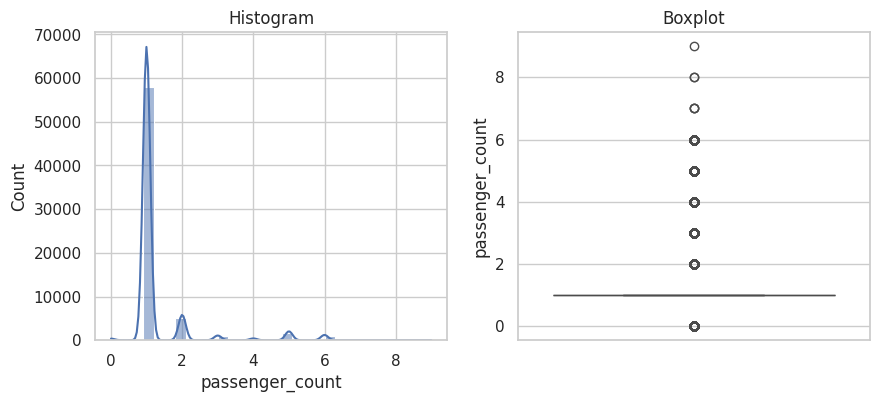


Skewness Value :  3.6380597789555438


In [ ]:
diagnostic_plots(df, 'passenger_count')
print('\nSkewness Value : ', df['passenger_count'].skew())

In [ ]:
print('Max of Passenger:', df['passenger_count'].max())
print('Min of Passenger:', df['passenger_count'].min())
print('Mean of Passenger:' ,df['passenger_count'].mean())

Max of Passenger: 9
Min of Passenger: 0
Mean of Passenger: 1.2964706930869552


Most trips have 1 passenger. Records with 0 passengers are likely input errors and can be removed. The maximum number of passengers is 5, with 1 additional passenger allowed for a child under 7 years old

In [ ]:
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

### Trip Distance

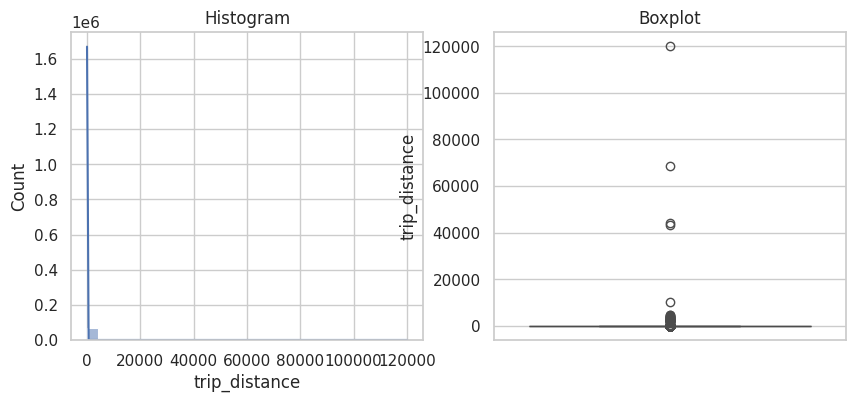


Skewness Value :  161.48788142383282


In [ ]:
diagnostic_plots(df, 'trip_distance')
print('\nSkewness Value : ', df['trip_distance'].skew())

In [ ]:
print('Longest Trip Distance :', df['trip_distance'].max())
print('Nearest Trip Distance :', df['trip_distance'].min())
print('Average Trip Distance :', df['trip_distance'].mean())

Longest Trip Distance : 120098.84
Nearest Trip Distance : 0.0
Average Trip Distance : 8.195591694778637


The minimum trip distance should be greater than 0.25 miles (400 meters), as shorter distances are most likely due to input errors.

In [ ]:
df = df[df['trip_distance'] >= 0.25]

In [ ]:
from scipy.stats import shapiro

stat, pvalue =shapiro(df['trip_distance'])
alpha = 0.05

if pvalue > alpha:
    print(f'pvalue: {pvalue}. pvalue > {alpha}, Fail to reject H0, we can assume that the data is normally distributed.')
else:
    print(f'pvalue: {pvalue}. pvalue < {alpha}, Reject H0, we can assume that the data is not normally distributed.')

pvalue: 6.474919665312056e-171. pvalue < 0.05, Reject H0, we can assume that the data is not normally distributed.


In [ ]:
median_by_zone = (
    df.groupby(['PULocationID', 'DOLocationID'])['trip_distance']
    .median()
    .reset_index()
    .rename(columns={'trip_distance': 'median_dist'})
)
median_by_zone

,PULocationID,DOLocationID,median_dist
0,3,3,1.150
1,3,51,1.090
2,3,74,13.900
3,3,243,6.500
4,3,247,5.590
...,...,...,...
5007,263,244,5.210
5008,263,256,8.840
5009,263,261,8.780
5010,263,262,1.080


In [ ]:
median_by_zone = df[df['trip_distance'] < 40].groupby(
    ['PULocationID', 'DOLocationID']
)['trip_distance'].median().reset_index(name='median_dist')

# 2. Merge median ke dataframe
df = df.merge(median_by_zone, on=['PULocationID', 'DOLocationID'], how='left')

# 3. Replace trip_distance > 40 dengan median dari PU-DO zone
df.loc[df['trip_distance'] > 40, 'trip_distance'] = df.loc[df['trip_distance'] > 40, 'median_dist']

# 4. Hapus kolom median_dist
df = df.drop(columns=['median_dist'])

Based on the normality test, trip_distance is not normally distributed. Therefore, outliers are handled using the median distance by pickup (PULocationID) and drop-off (DOLocationID) zones. Trips longer than 40 miles are considered unrealistic—likely due to the meter not being turned off by the driver—so these values are replaced with the median distance for the corresponding PU-DO zone. Only trips under 40 miles are used to calculate the median.

### Fare Amount

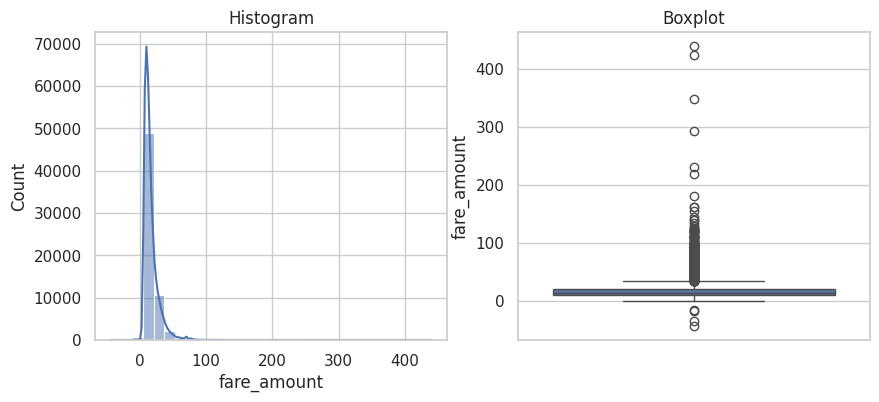


Skewness Value :  4.706001457490062


In [ ]:
diagnostic_plots(df, 'fare_amount')
print('\nSkewness Value : ', df['fare_amount'].skew())

### Total Amount

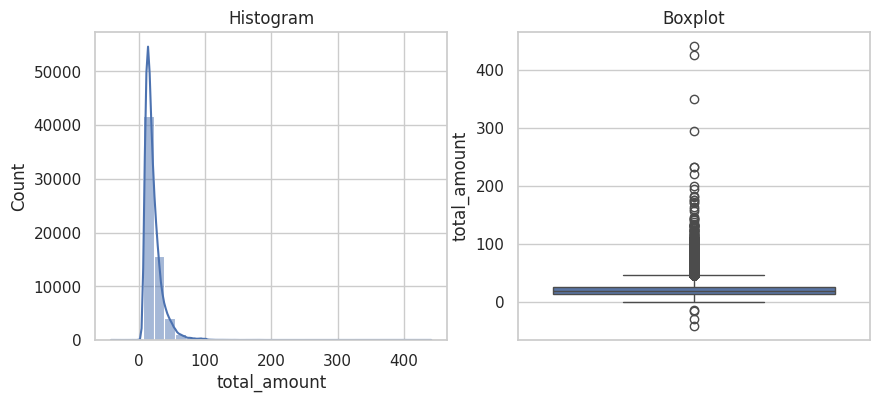


Skewness Value :  3.6768964425172954


In [ ]:
diagnostic_plots(df, 'total_amount')
print('\nSkewness Value : ', df['total_amount'].skew())

In [ ]:
print('Highest Total Amount  :', df['total_amount'].max())
print('Lowest Total Amount   :', df['total_amount'].min())
print('Average Total Amount  :', df['total_amount'].mean())

Highest Total Amount  : 441.0
Lowest Total Amount   : -41.78
Average Total Amount  : 21.658483319669546


In [ ]:
df[df['total_amount'] < 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
59865,2,2023-01-05 10:51:00,2023-01-05 11:20:00,N,1.0,116,151,1,2.22,-43.54,0.76,-41.78,4.0,1.0,0.0,Manhattan,Hamilton Heights,Boro Zone,Manhattan,Manhattan Valley,Yellow Zone,29.0,10,11,Morning,Morning,Thursday,Thursday,2023,2023
60461,2,2023-01-10 10:00:00,2023-01-10 10:26:00,N,1.0,168,159,1,3.45,-17.38,0.26,-16.12,4.0,1.0,0.0,Bronx,Mott Haven/Port Morris,Boro Zone,Bronx,Melrose South,Boro Zone,26.0,10,10,Morning,Morning,Tuesday,Tuesday,2023,2023
61747,2,2023-01-19 17:48:00,2023-01-19 17:52:00,N,1.0,166,166,1,0.38,-35.01,4.86,-29.15,4.0,1.0,0.0,Manhattan,Morningside Heights,Boro Zone,Manhattan,Morningside Heights,Boro Zone,4.0,17,17,Evening,Evening,Thursday,Thursday,2023,2023
62707,2,2023-01-26 10:10:00,2023-01-26 10:20:00,N,1.0,248,126,1,1.51,-15.53,0.22,-14.31,4.0,1.0,0.0,Bronx,West Farms/Bronx River,Boro Zone,Bronx,Hunts Point,Boro Zone,10.0,10,10,Morning,Morning,Thursday,Thursday,2023,2023


Based on the histogram, total_amount is positively skewed. The boxplot shows outliers both below the bottom whisker and above the upper whisker. Therefore, negative values likely occur due to disputes.

### Trip Duration

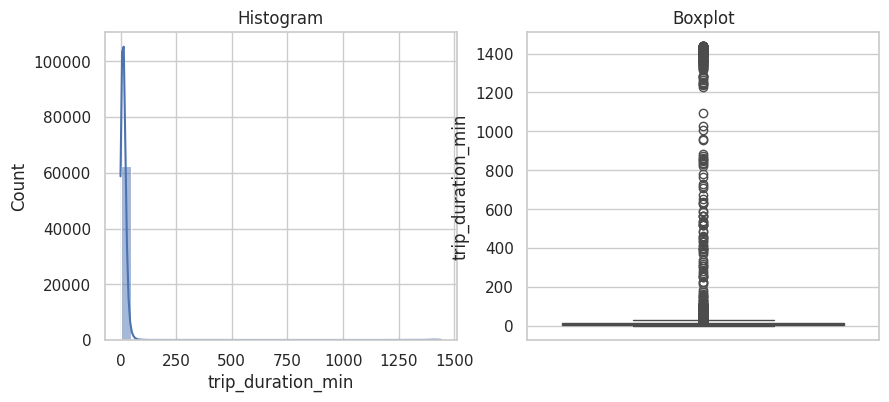


Skewness Value :  17.481011556120155


In [ ]:
diagnostic_plots(df, 'trip_duration_min')
print('\nSkewness Value : ', df['trip_duration_min'].skew())

In [ ]:
print('Longest Trip Duration (min) :', df['trip_duration_min'].max())
print('Shortest Trip Duration (min):', df['trip_duration_min'].min())
print('Average Trip Duration (min) :', df['trip_duration_min'].mean())

Longest Trip Duration (min) : 1438.9333333333334
Shortest Trip Duration (min): 0.0
Average Trip Duration (min) : 18.06818019381556


In [ ]:
df[df['trip_duration_min'] == 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_type,congestion_surcharge,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,trip_duration_min,PU_Hour,DO_Hour,PU_dayperiod,DO_dayperiod,PU_dayname,DO_dayname,PU_Year,DO_Year
6632,1,2023-01-05 07:54:34,2023-01-05 07:54:34,N,1.0,42,42,1,1.9,12.8,0.0,14.3,2.0,1.0,0.0,Manhattan,Central Harlem North,Boro Zone,Manhattan,Central Harlem North,Boro Zone,0.0,7,7,Morning,Morning,Thursday,Thursday,2023,2023


In [ ]:
Q1 = df['trip_duration_min'].quantile(0.01)
Q3 = df['trip_duration_min'].quantile(0.99)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
upper_bound

np.float64(132.28699999999915)

In [ ]:
df = df[(df['trip_duration_min'] >= 1) & (df['trip_duration_min'] <= upper_bound)]

Based on the histogram, the trip duration distribution is positively skewed. The boxplot also shows many outliers above the upper whisker, which means there are trips that took longer than normal. However, since trip duration can be influenced by traffic, these can still be valid outliers. Therefore, the upper bound of the duration is not strict (I’m using the 1st and 99th percentiles). The lower bound is greater than 0 minutes because a duration of 0 minutes indicates a cancelled trip or an error.

### Year

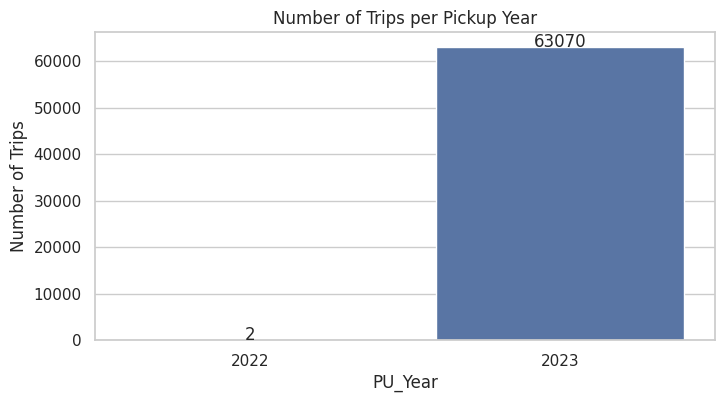

In [ ]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='PU_Year', data=df)


for p in ax.patches:
    height = p.get_height()               # tinggi bar
    ax.text(
        p.get_x() + p.get_width()/2,     # posisi x (tengah bar)
        height + 5,                      # posisi y (sedikit di atas bar)
        f'{int(height)}',                # labelnya
        ha='center'                      # horizontal alignment
    )

plt.title('Number of Trips per Pickup Year')
plt.ylabel('Number of Trips')
plt.show()

In [ ]:
df = df[(df['PU_Year'] == 2023) & (df['DO_Year'] == 2023)]

The majority of the trips recorded in this dataset are from 2023, so years other than 2023 will not be included.

# Data Analysis

### Proportion of Categorical Col

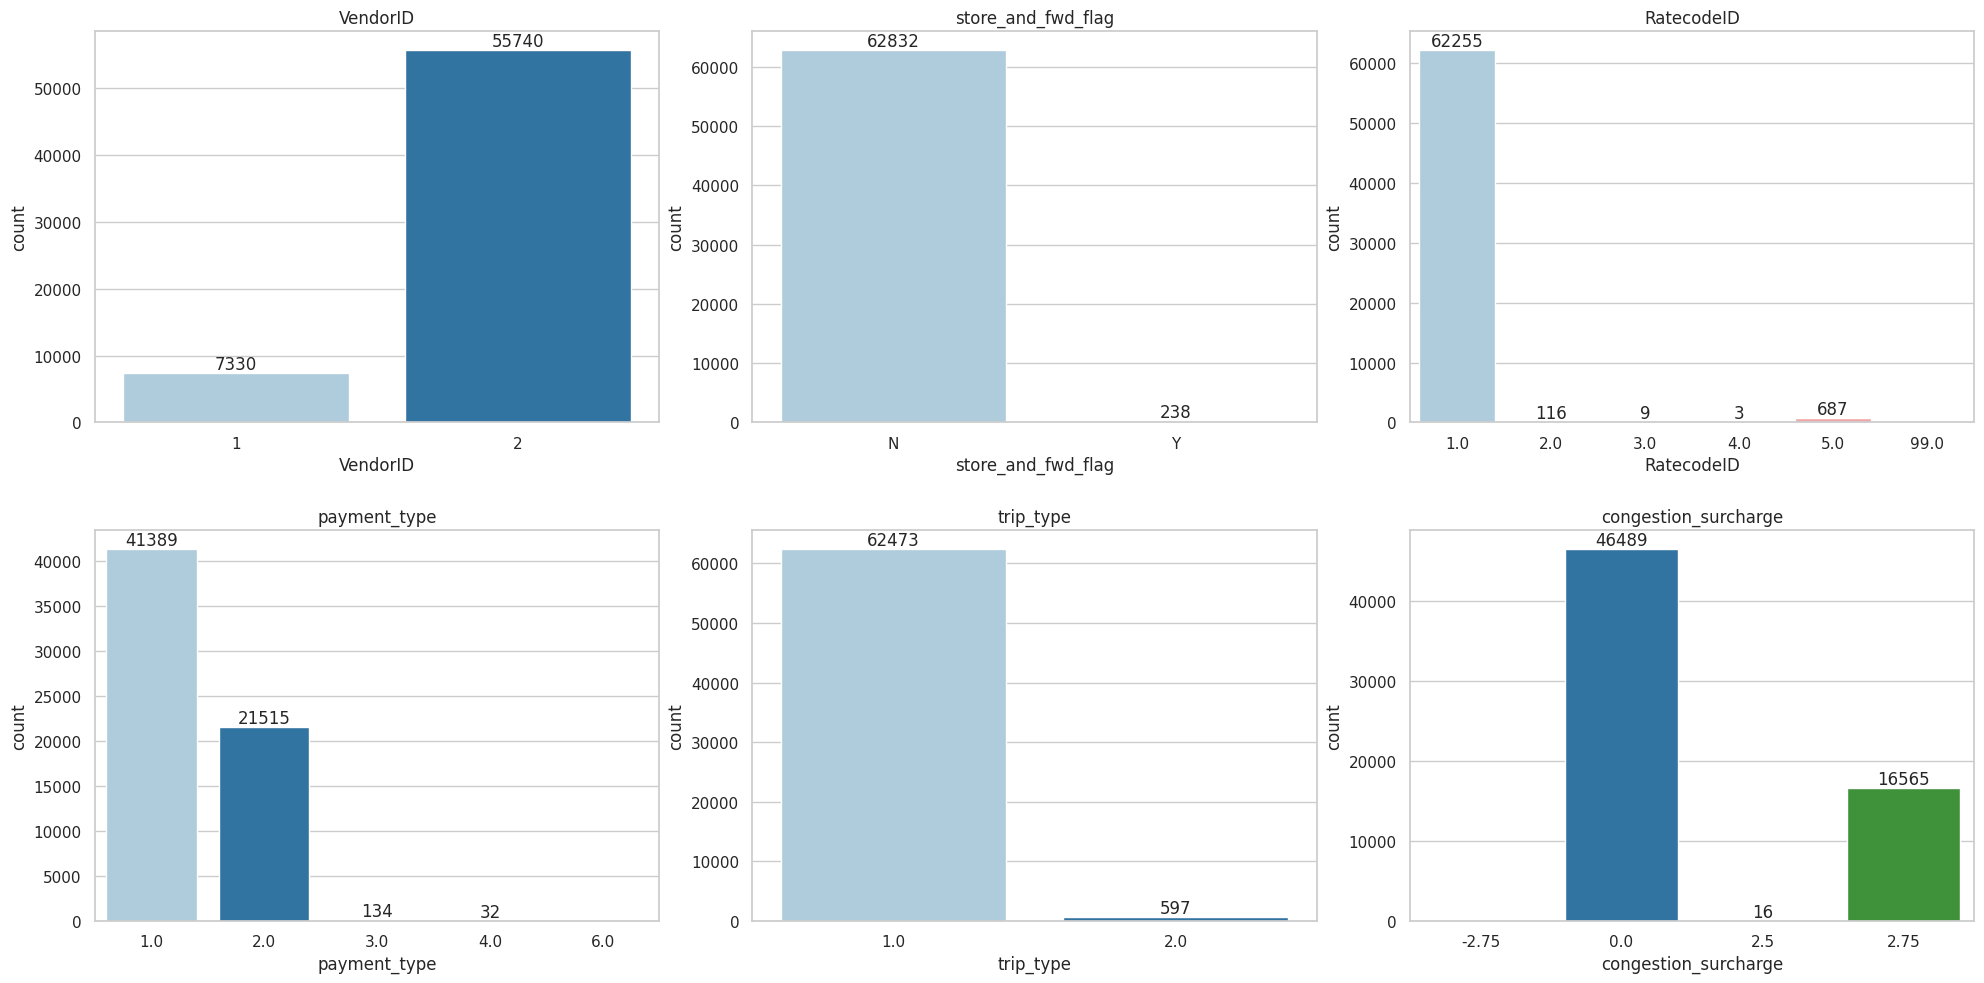

In [ ]:
cols = df.select_dtypes(include='category').columns
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axs = axs.flatten()

for i, col in enumerate(cols):
    bars = sns.countplot(data=df, x=col, palette=color, ax=axs[i])
    axs[i].set_title(col)
    for idx, bar in enumerate(bars.patches):
        x_value = bar.get_x() + bar.get_width() / 2
        y_value = bar.get_height()
        label = "{:.0f}".format(bar.get_height())
        axs[i].text(x_value, y_value, label, ha='center', va='bottom')

plt.tight_layout(w_pad=0.5, h_pad=2)
plt.show()

## Correlation

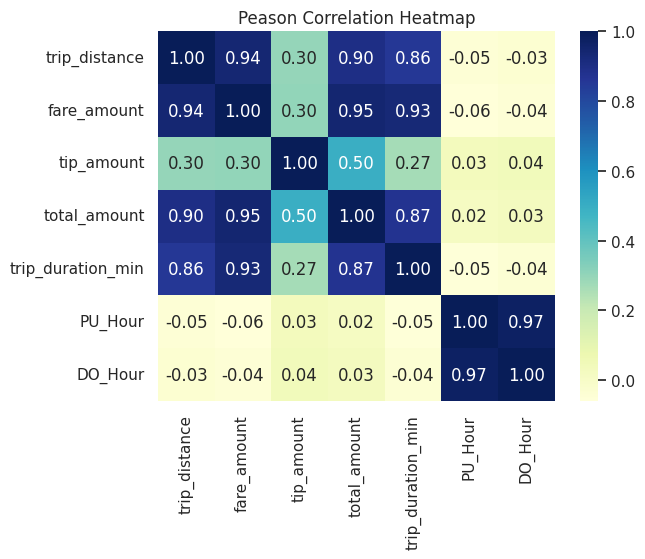

In [ ]:
corr = df[['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_duration_min', 'PU_Hour', 'DO_Hour']].corr(method='spearman')

sns.heatmap(corr, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Peason Correlation Heatmap')
plt.show()

- Trip distance, fare, total amount, and trip duration are strongly interconnected, reflecting the logical structure of taxi pricing.
- Tip amount shows only moderate correlation, suggesting it depends more on other behavioral or contextual factors.
- Time of day (pickup/drop-off hours) does not strongly affect fare or distance but is highly consistent within the same trip.

## Trip Patterns

In [ ]:
def add_bar_labels(ax, fmt='{:,.0f}', fontsize=10, offset=0.01):
  for p in ax.patches:
        height = p.get_height()
        ax.annotate(fmt.format(height),
                    (p.get_x() + p.get_width() / 2., height + offset * height),
                    ha='center', va='bottom',
                    fontsize=fontsize)

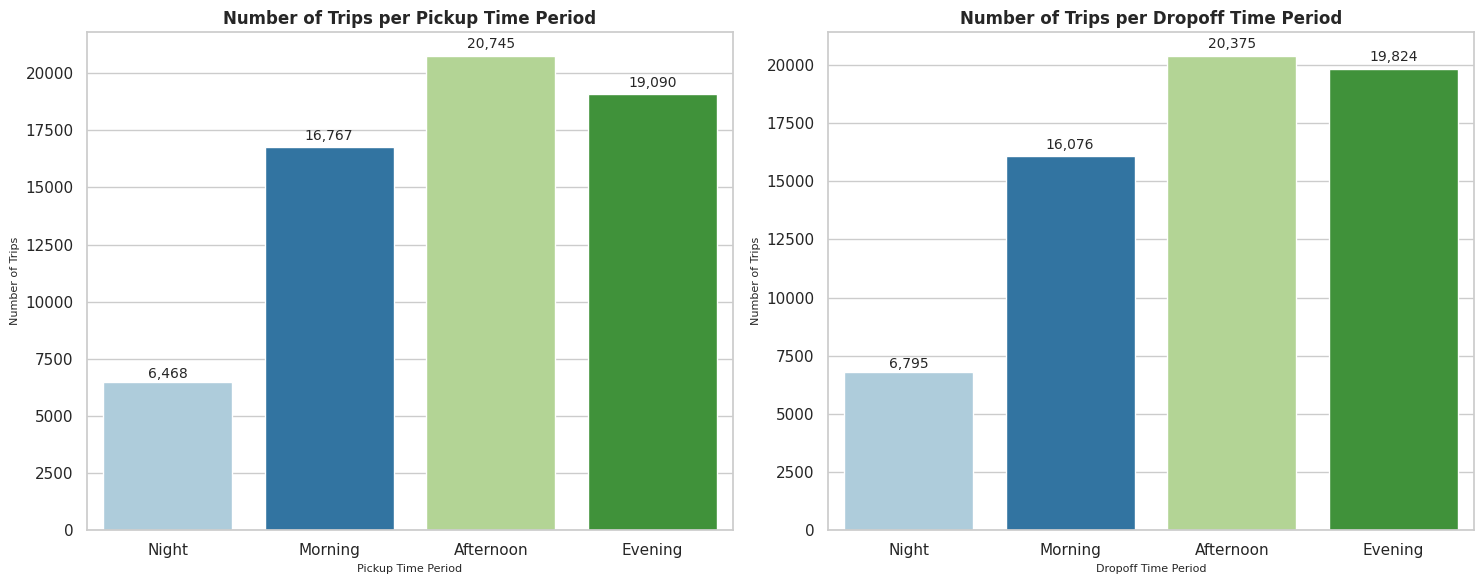

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6))

ax1 = sns.countplot(x = 'PU_dayperiod', data=df, palette = color, ax=ax1)
add_bar_labels(ax1)
ax1.set_title('Number of Trips per Pickup Time Period', fontsize=12, fontweight='bold')
ax1.set_xlabel('Pickup Time Period', fontsize=8)
ax1.set_ylabel('Number of Trips', fontsize=8)


ax2 = sns.countplot(x = 'DO_dayperiod', data=df, palette = color, ax=ax2)
add_bar_labels(ax2)
ax2.set_title('Number of Trips per Dropoff Time Period', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dropoff Time Period', fontsize=8)
ax2.set_ylabel('Number of Trips', fontsize=8)

plt.tight_layout()
plt.show()

The data shows that most taxi trips happen in the afternoon (12 PM to 5 PM). This is likely because many people are returning home from work during those hours.

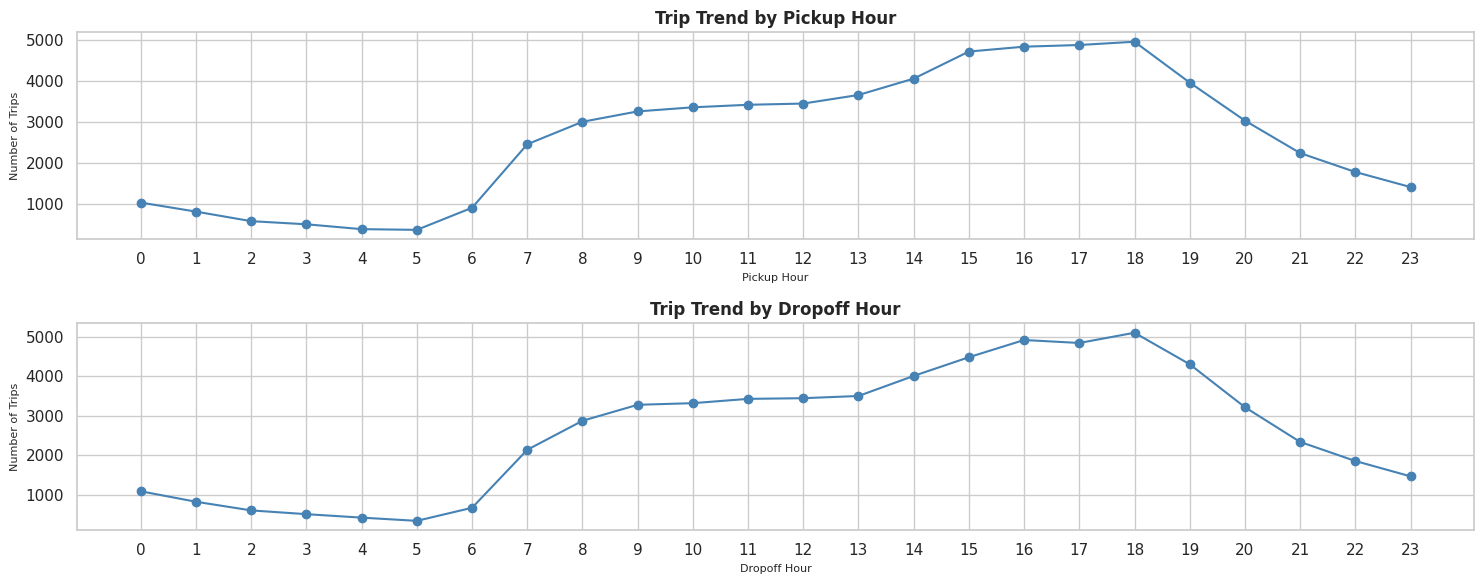

In [ ]:
pickup_counts = df['PU_Hour'].value_counts().sort_index()
dropoff_counts = df['DO_Hour'].value_counts().sort_index()

fig, (ax3,ax4) = plt.subplots(nrows=2, figsize=(15,6))

ax3.plot(pickup_counts.index, pickup_counts.values, marker='o', linestyle='-', color='steelblue')
ax3.set_title('Trip Trend by Pickup Hour', fontsize=12, fontweight='bold')
ax3.set_xlabel('Pickup Hour', fontsize=8)
ax3.set_ylabel('Number of Trips', fontsize=8)
ax3.set_xticks(range(0, 24))

ax4.plot(dropoff_counts.index, dropoff_counts.values, marker='o', linestyle='-', color='steelblue')
ax4.set_title('Trip Trend by Dropoff Hour', fontsize=12, fontweight='bold')
ax4.set_xlabel('Dropoff Hour', fontsize=8)
ax4.set_ylabel('Number of Trips', fontsize=8)
ax4.set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

The hourly trend of trips confirms that most taxi trips happen in the afternoon, with a noticeable increase between 1 PM and 6 PM. This is likely because many people are  going out for activities like lunch or errands during these hours. The peak hours between 4 PM and 6 PM likely represent the time when the majority of commuters are heading home. After that period, the number of trips starts to decline.

The decline probably happens because most people have already finished commuting for the day, so there is less demand for transportation later in the evening.

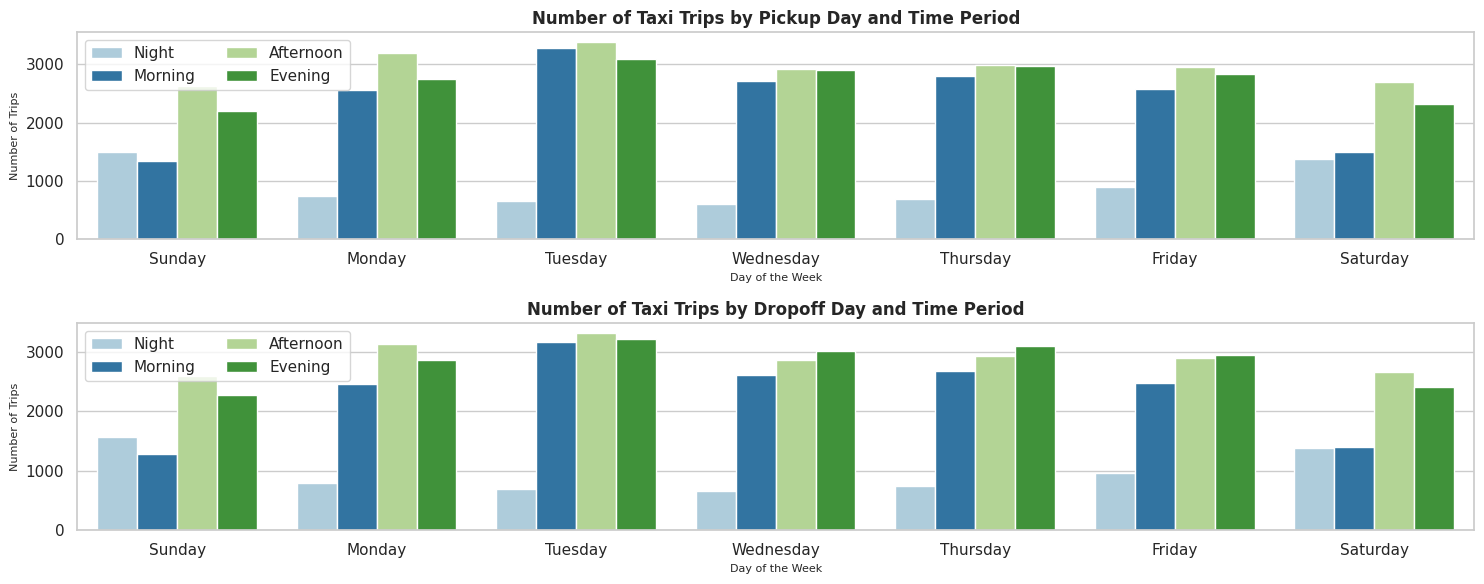

In [ ]:
fig, (ax5,ax6) = plt.subplots(nrows=2, figsize=(15,6))

ax5 = sns.countplot(x = 'PU_dayname', data=df, palette = color, hue =df['PU_dayperiod'], ax=ax5)
ax5.set_title('Number of Taxi Trips by Pickup Day and Time Period', fontsize=12, fontweight='bold')
ax5.set_xlabel('Day of the Week', fontsize=8)
ax5.set_ylabel('Number of Trips', fontsize=8)
ax5.legend(loc='upper left', ncol=2)

ax6 = sns.countplot(x = 'DO_dayname', data=df, palette = color, hue =df['DO_dayperiod'], ax=ax6)
ax6.set_title('Number of Taxi Trips by Dropoff Day and Time Period', fontsize=12, fontweight='bold')
ax6.set_xlabel('Day of the Week', fontsize=8)
ax6.set_ylabel('Number of Trips', fontsize=8)
ax6.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

In [ ]:
df['PU_dayname'].value_counts()

,count
PU_dayname,
Tuesday,10414
Thursday,9448
Friday,9277
Monday,9241
Wednesday,9138
Saturday,7875
Sunday,7677


Most trips happen on weekdays (especially on Tuesday), followed by Thursday and Friday, because those days fall during office and school hours. Also, people tend to hang out after work on Thursday and Friday, which is why most drop-offs on those days happen in the evening. On the other hand, weekends see relatively low activity.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63070 entries, 0 to 63427
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               63070 non-null  category      
 1   lpep_pickup_datetime   63070 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  63070 non-null  datetime64[ns]
 3   store_and_fwd_flag     63070 non-null  category      
 4   RatecodeID             63070 non-null  category      
 5   PULocationID           63070 non-null  int64         
 6   DOLocationID           63070 non-null  int64         
 7   passenger_count        63070 non-null  Int64         
 8   trip_distance          63063 non-null  float64       
 9   fare_amount            63070 non-null  float64       
 10  tip_amount             63070 non-null  float64       
 11  total_amount           63070 non-null  float64       
 12  payment_type           63070 non-null  category      
 13  trip_t

In [ ]:
hourly_stats = df.groupby('PU_Hour').agg(
    trip_count=('VendorID', 'count'),
    total_passengers=('passenger_count', 'sum')
).reset_index()

# Rasio demand terhadap supply
hourly_stats['avg_passenger_pertrip'] = hourly_stats['total_passengers'] / hourly_stats['trip_count']

hourly_stats.sort_values(by='avg_passenger_pertrip', ascending=False)

,PU_Hour,trip_count,total_passengers,avg_passenger_pertrip
5,5,361,543,1.504155
2,2,573,828,1.445026
3,3,497,707,1.422535
4,4,378,529,1.399471
1,1,807,1125,1.394052
23,23,1408,1900,1.349432
10,10,3360,4532,1.34881
7,7,2456,3276,1.333876
0,0,1028,1371,1.333658
8,8,3006,3992,1.328011


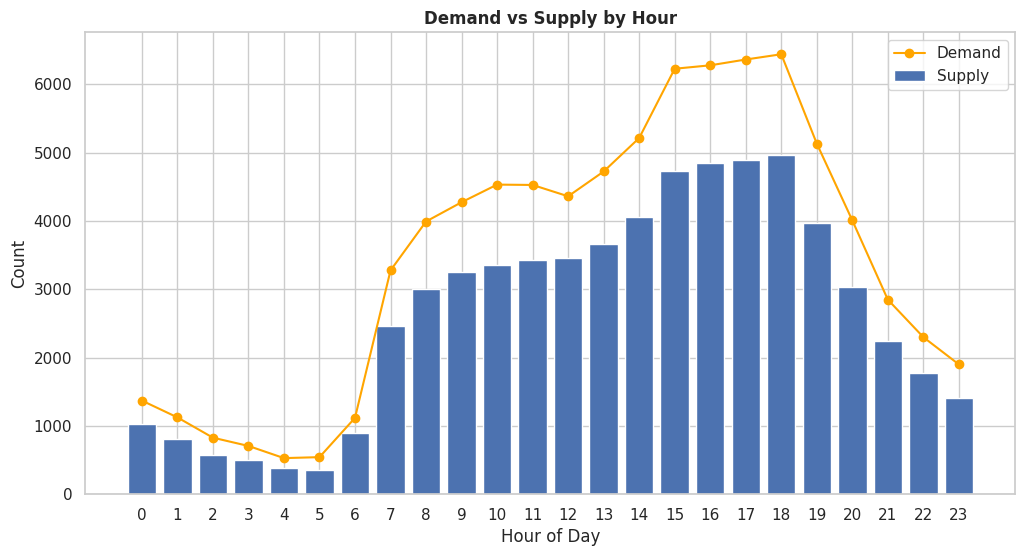

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(hourly_stats['PU_Hour'], hourly_stats['trip_count'], label='Supply')
plt.plot(hourly_stats['PU_Hour'], hourly_stats['total_passengers'], label='Demand', marker='o', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Demand vs Supply by Hour', fontsize=12, fontweight='bold')
plt.legend()
plt.xticks(range(0, 24))
plt.show()

The lowest supply recorded by vendor is at 5 AM, and the highest demand is at 6 PM. But at 6 PM, ratio of demand and supply is good — meaning that although demand is high, supply is also high. Meanwhile, night hours (1 - 5 AM) have low supply but still notable demand, causing higher pressure per available trip. which indicates that the supply might not be enough to meet the demand during those hours.

In [ ]:
df['trip_type'].value_counts()

,count
trip_type,
1.0,62473
2.0,597


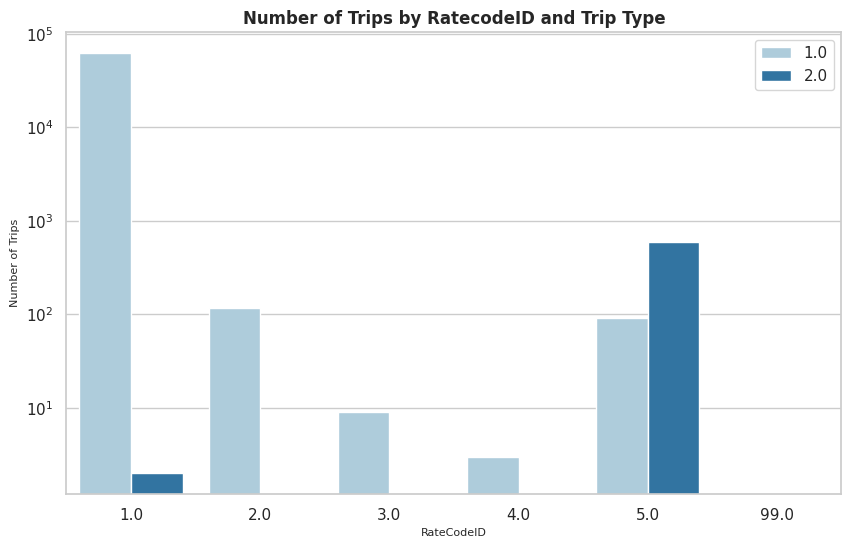

In [ ]:
fig, ax7 = plt.subplots(figsize=(10,6))

ax7 = sns.countplot(x = 'RatecodeID', data=df, palette = color, hue =df['trip_type'], ax=ax7)
ax7.set_title('Number of Trips by RatecodeID and Trip Type', fontsize=12, fontweight='bold')
ax7.set_xlabel('RateCodeID', fontsize=8)
ax7.set_ylabel('Number of Trips', fontsize=8)
ax7.legend(loc='upper right')
ax7.set_yscale('log')


plt.show()

The graph shows that the standard rate (RatecodeID 1) has the highest number of trips, with most trips classified as street hail. This makes sense because the standard rate typically applies to regular taxi fares, where passengers hail taxis directly from the street.

Meanwhile, for the negotiated rate (RatecodeID 5), most trips fall under the dispatch trip type. This is likely because negotiated rates are often arranged through pre-booking or contracts, such as corporate accounts, rides arranged through a dispatcher, or pre-scheduled rides, rather than random street hails.

## Pricing Patterns

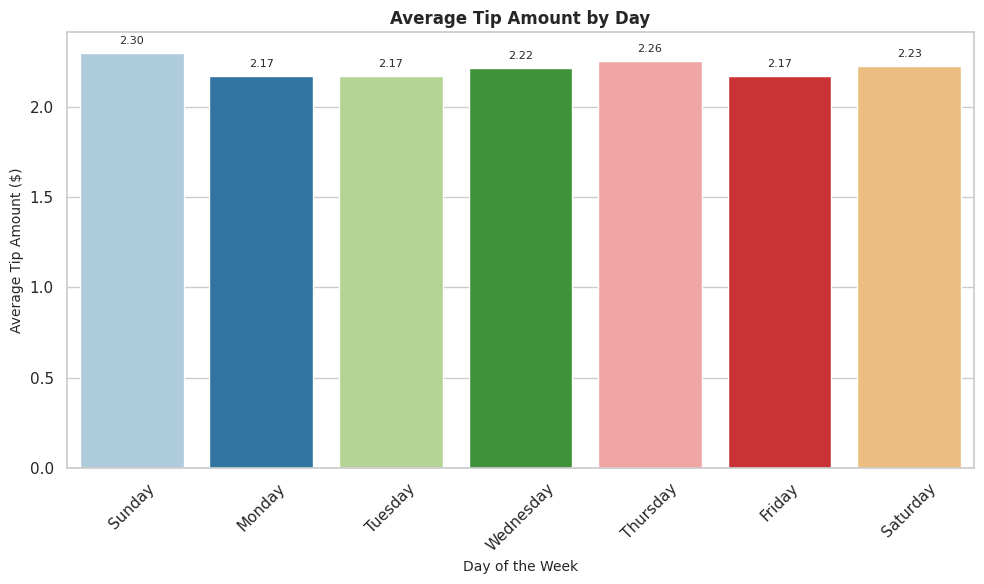

In [ ]:
fig, ax8 = plt.subplots(figsize=(10,6))

tip_perday = sns.barplot(x = 'DO_dayname', y = 'tip_amount', data=df, estimator='mean', palette=color, ax=ax8, ci=None)


for bar in tip_perday.patches:
    height = bar.get_height()
    ax8.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom',
                 fontsize=8)


ax8.set_title('Average Tip Amount by Day', fontsize=12, fontweight='bold')
ax8.set_xlabel('Day of the Week', fontsize=10)
ax8.set_ylabel('Average Tip Amount ($)', fontsize=10)
ax8.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

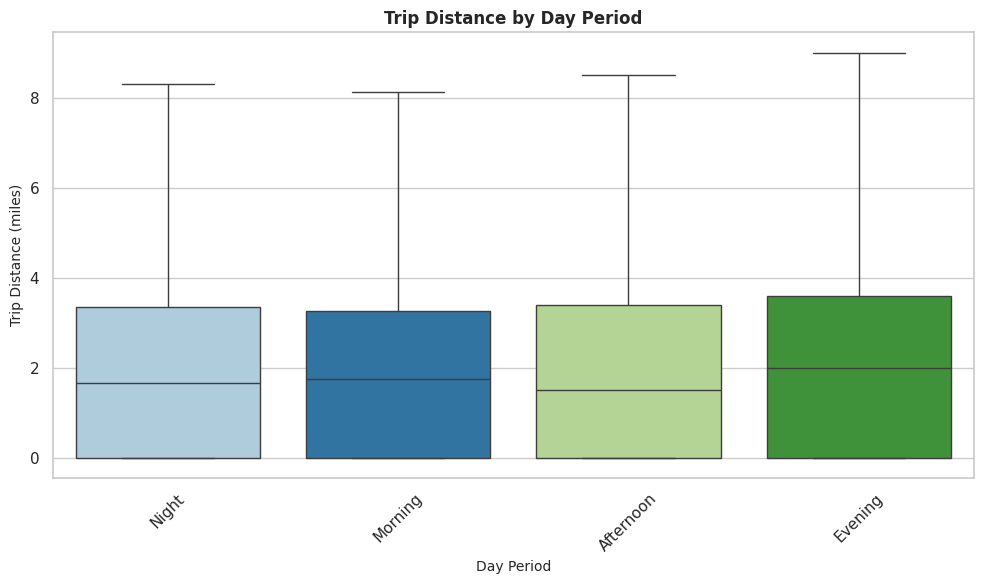

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(
    x='DO_dayperiod',
    y='tip_amount',
    data=df,
    palette=color,
    ax=ax,
    showfliers=False
)

ax.set_title('Trip Distance by Day Period', fontsize=12, fontweight='bold')
ax.set_xlabel('Day Period', fontsize=10)
ax.set_ylabel('Trip Distance (miles)', fontsize=10)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


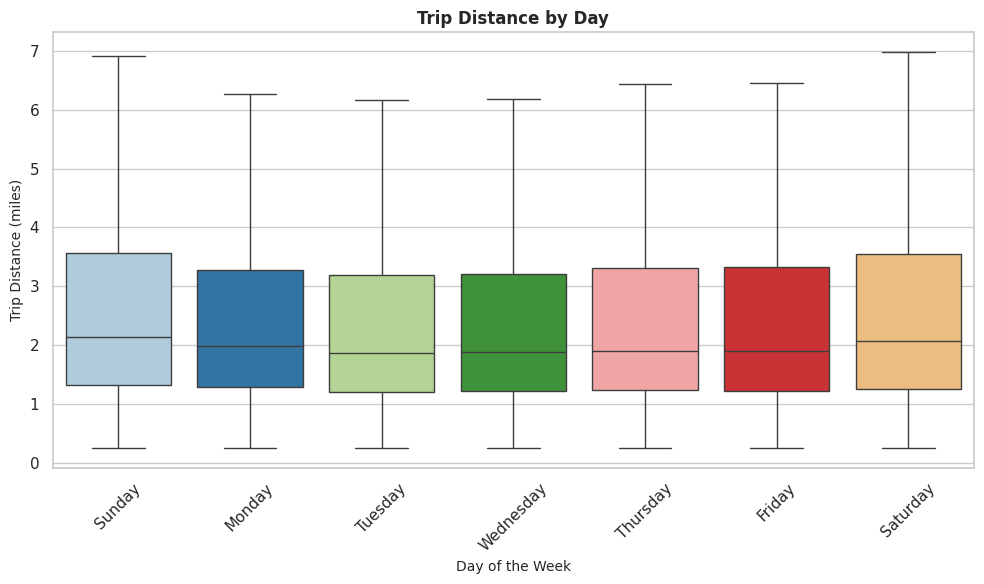

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.boxplot(
    x='DO_dayname',
    y='trip_distance',
    data=df,
    palette=color,
    ax=ax,
    showfliers=False
)

ax.set_title('Trip Distance by Day', fontsize=12, fontweight='bold')
ax.set_xlabel('Day of the Week', fontsize=10)
ax.set_ylabel('Trip Distance (miles)', fontsize=10)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Based on the Average Tip Amount by Day barplot, the highest tips occur on Sunday, followed by Thursday and Saturday. The boxplot of trip distance shows that Sunday has the longest trips compared to other days, as indicated by the highest Q3 and upper whisker values.

Although trip distances on Thursday are shorter than those on Saturday, the average tip on Thursday is higher. This might be because the evening period on Thursday has the highest number of trips (ax5,6), while Saturday’s peak occurs in the afternoon. This suggests that higher tips are more common during longer trips and evening trips, possibly due to different trip purposes or social behaviors

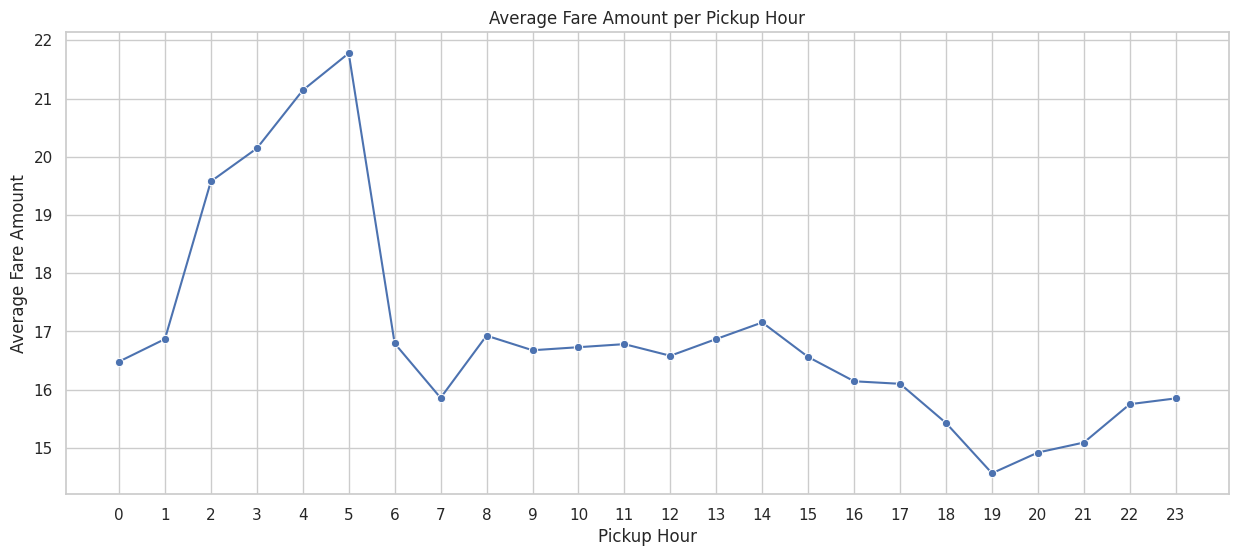

In [ ]:
df_filtered = df[df['payment_type'] != 4]

# Aggregate mean fare per pickup hour
fare_by_hour = df_filtered.groupby('PU_Hour')['fare_amount'].mean().reset_index()


# Visualisasi
plt.figure(figsize=(15,6))
sns.lineplot(data=fare_by_hour, x='PU_Hour', y='fare_amount', marker='o')
plt.title('Average Fare Amount per Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Average Fare Amount')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

Based on the lineplot, the highest average fare amount occurs at 5 AM. This aligns with a demand-supply perspective on trip behavior: during this early morning hour, the taxi supply is relatively low while demand—though not peak—is enough to create upward pressure on fares. As a result, the fare tends to be higher compared to other hours.

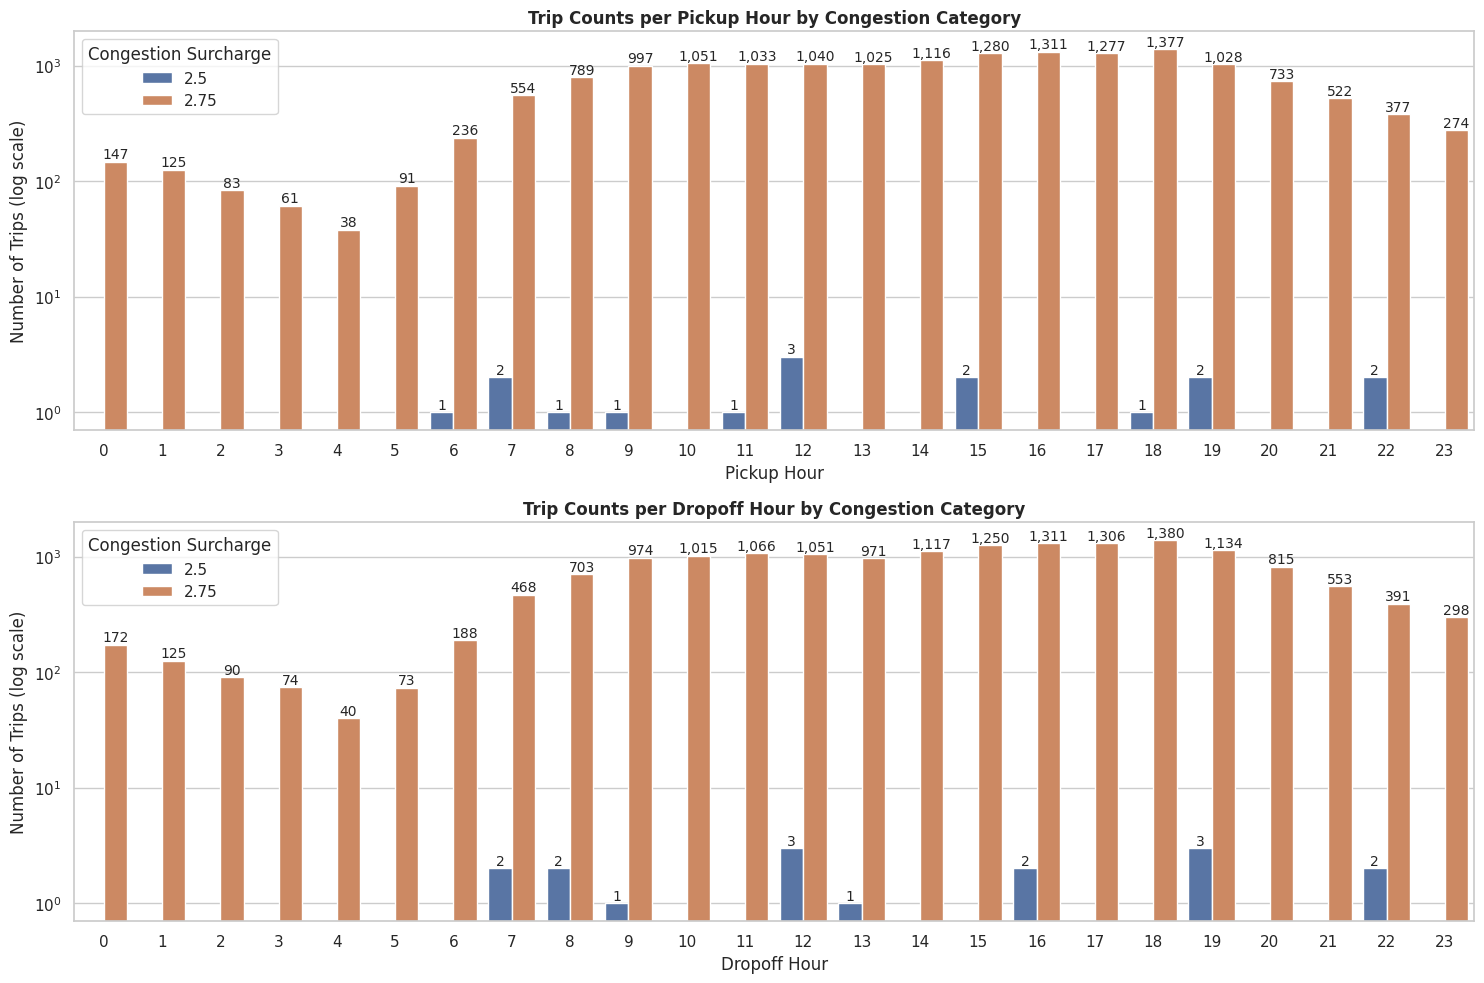

In [ ]:
congestion_filtered = df[df['congestion_surcharge'].isin([2.5, 2.75])].copy()
congestion_filtered['congestion_surcharge'] = congestion_filtered['congestion_surcharge'].cat.set_categories([2.5, 2.75])

fig, (ax21, ax22) = plt.subplots(nrows=2, figsize=(15,10))

sns.countplot(data=congestion_filtered, x='PU_Hour', hue='congestion_surcharge', ax=ax21)
add_bar_labels(ax21)
ax21.set_yscale('log')
ax21.set_title('Trip Counts per Pickup Hour by Congestion Category', fontsize=12, fontweight='bold')
ax21.set_xlabel('Pickup Hour')
ax21.set_ylabel('Number of Trips (log scale)')
ax21.legend(title='Congestion Surcharge')


sns.countplot(data=congestion_filtered, x='DO_Hour', hue='congestion_surcharge',  ax=ax22)
add_bar_labels(ax22)
ax22.set_yscale('log')
ax22.set_title('Trip Counts per Dropoff Hour by Congestion Category', fontsize=12, fontweight='bold')
ax22.set_xlabel('Dropoff Hour')
ax22.set_ylabel('Number of Trips (log scale)')
ax22.legend(title='Congestion Surcharge')

plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

Based on the graph, the congestion surcharge category 2.75 gradually increases in the afternoon, starting around 1 PM and peaking at 6 PM. This pattern indicates that traffic congestion intensifies toward the evening, after which it begins to decline.

Meanwhile, the 2.5 surcharge category reaches its highest count around 12 PM, suggesting a midday peak in moderate congestion, possibly corresponding to lunch-time traffic or standard peak-hour conditions that incur a lower surcharge.

## Area Distribution

In [ ]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'PU_Borough', 'PU_Zone', 'PU_service_zone', 'DO_Borough', 'DO_Zone',
       'DO_service_zone', 'trip_duration_min', 'PU_Hour', 'DO_Hour',
       'PU_dayperiod', 'DO_dayperiod', 'PU_dayname', 'DO_dayname', 'PU_Year',
       'DO_Year'],
      dtype='object')

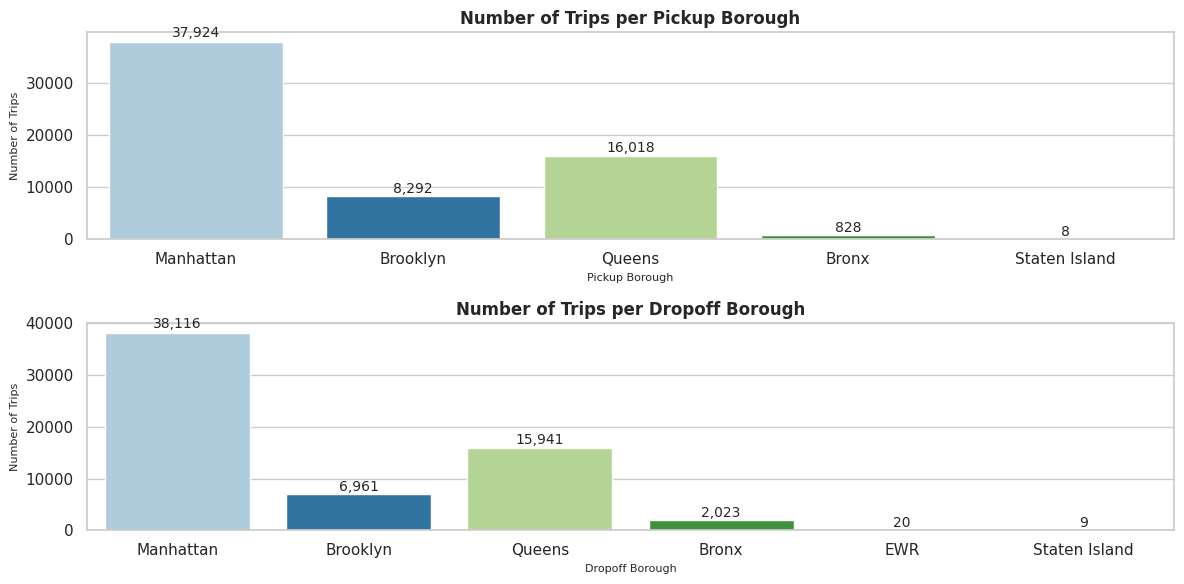

In [ ]:
fig, (ax11,ax12) = plt.subplots(nrows=2, figsize=(12,6))

ax11 = sns.countplot(x = 'PU_Borough', data=df, palette = color, ax=ax11)
add_bar_labels(ax11)
ax11.set_title('Number of Trips per Pickup Borough', fontsize=12, fontweight='bold')
ax11.set_xlabel('Pickup Borough', fontsize=8)
ax11.set_ylabel('Number of Trips', fontsize=8)


ax12 = sns.countplot(x = 'DO_Borough', data=df, palette = color, ax=ax12)
add_bar_labels(ax12)
ax12.set_title('Number of Trips per Dropoff Borough', fontsize=12, fontweight='bold')
ax12.set_xlabel('Dropoff Borough', fontsize=8)
ax12.set_ylabel('Number of Trips', fontsize=8)

plt.tight_layout()
plt.show()

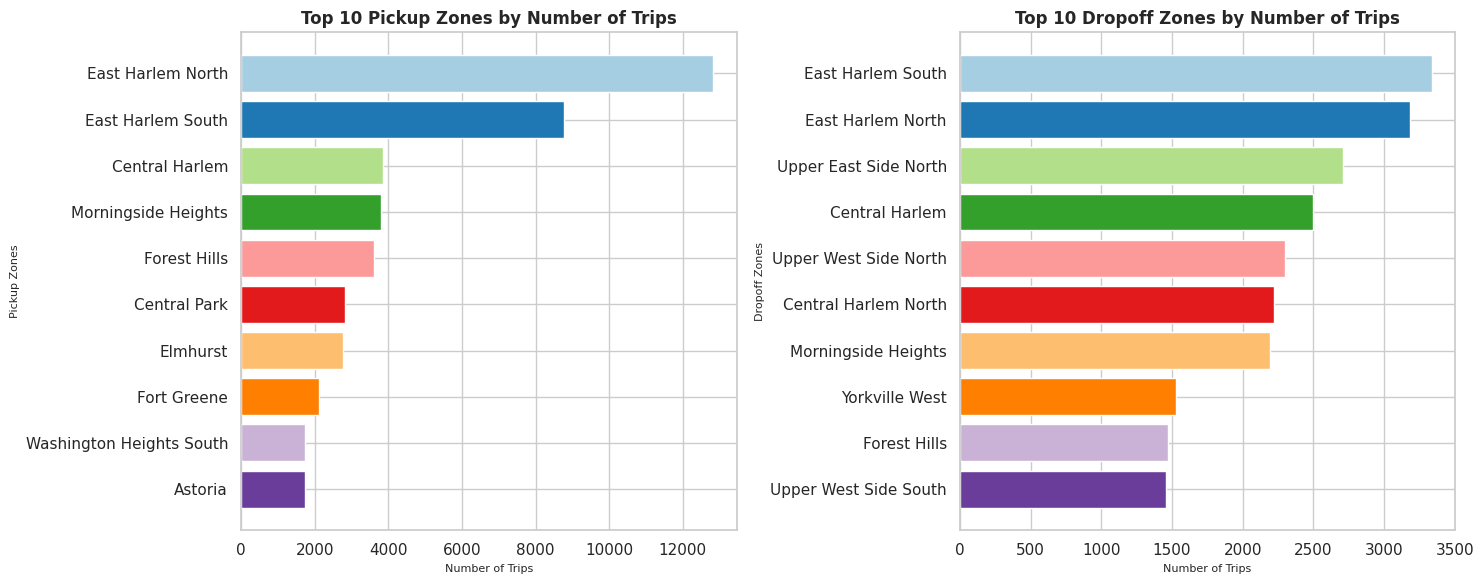

In [ ]:
top_10_pu_zones = df['PU_Zone'].value_counts().head(10)
top_10_do_zones = df['DO_Zone'].value_counts().head(10)

# Create subplots with updated axis names
fig, (ax13, ax14) = plt.subplots(ncols=2, figsize=(15, 6))

# Plot for Pickup Zones (Top 10)
ax13.barh(top_10_pu_zones.index, top_10_pu_zones.values, color=color)
ax13.set_title('Top 10 Pickup Zones by Number of Trips', fontsize=12, fontweight='bold')
ax13.set_xlabel('Number of Trips', fontsize=8)
ax13.set_ylabel('Pickup Zones', fontsize=8)
ax13.invert_yaxis()

# Plot for Dropoff Zones (Top 10)
ax14.barh(top_10_do_zones.index, top_10_do_zones.values, color=color)
ax14.set_title('Top 10 Dropoff Zones by Number of Trips', fontsize=12, fontweight='bold')
ax14.set_xlabel('Number of Trips', fontsize=8)
ax14.set_ylabel('Dropoff Zones', fontsize=8)
ax14.invert_yaxis()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Based on the graph, most trips occur in Manhattan, primarily because it has the highest concentration of businesses, tourist attractions, and major transportation hubs. It is followed by Queens, which is home to two major airports (JFK and LaGuardia), then Brooklyn, and finally Staten Island. Regarding the zones, East Harlem North and East Harlem South dominate the pickup and drop-off zones, which are both residential areas with significant transit connections to other parts of Manhattan. East Harlem South leads in drop-offs, followed closely by areas like Upper East Side North and Central Harlem. This suggests that many trips end in residential or commercially active areas, potentially for work, shopping, or leisure activities.

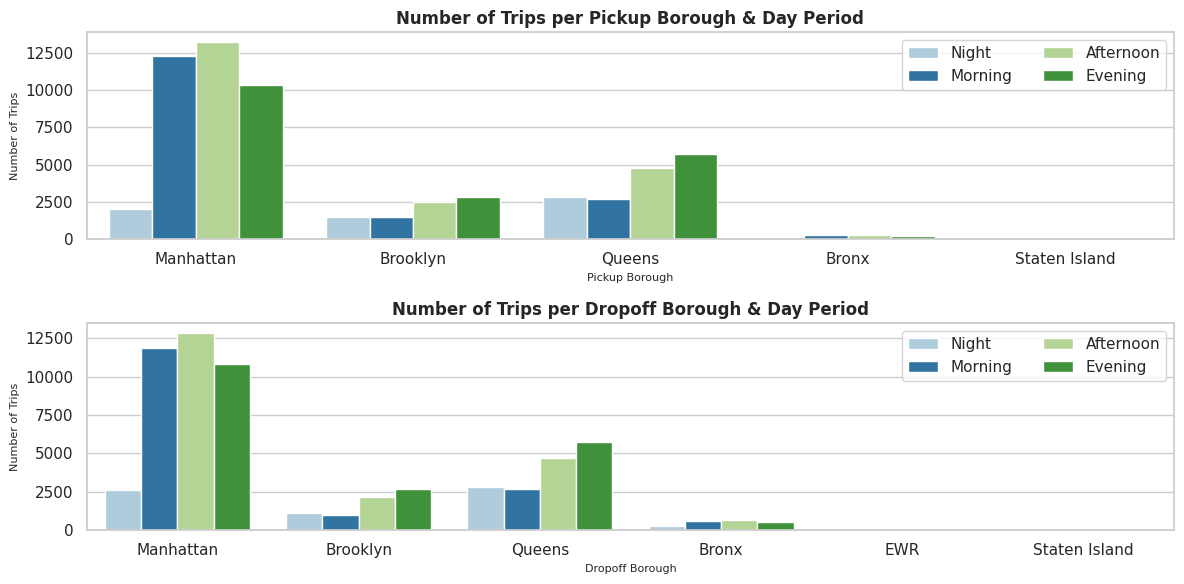

In [ ]:
fig, (ax15,ax16) = plt.subplots(nrows=2, figsize=(12,6))

ax15 = sns.countplot(x = 'PU_Borough', data=df, hue=df['PU_dayperiod'], palette = color, ax=ax15)
ax15.set_title('Number of Trips per Pickup Borough & Day Period', fontsize=12, fontweight='bold')
ax15.set_xlabel('Pickup Borough', fontsize=8)
ax15.set_ylabel('Number of Trips', fontsize=8)
ax15.legend(loc='upper right', ncol=2)

ax16 = sns.countplot(x = 'DO_Borough', data=df, hue=df['DO_dayperiod'], palette = color, ax=ax16)
ax16.set_title('Number of Trips per Dropoff Borough & Day Period' , fontsize=12, fontweight='bold')
ax16.set_xlabel('Dropoff Borough', fontsize=8)
ax16.set_ylabel('Number of Trips', fontsize=8)
ax16.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()

Based on the graph, Brooklyn and Queens have more trips in the evening compared to other periods, most likely because people are returning home, arriving from the airport, or going out for nightlife. In contrast, the Bronx shows higher trips in the morning compared to other boroughs, which could be related to commuting patterns such as people traveling to work

## Vendor Performance

Text(0, 0.5, 'Number of Trips')

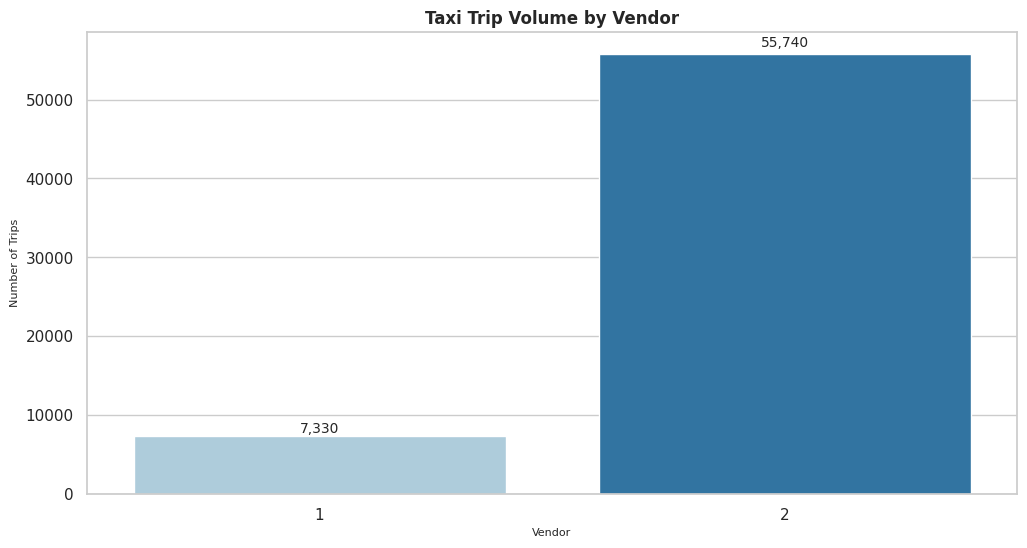

In [ ]:
fig, ax17 = plt.subplots(figsize=(12,6))

ax17 = sns.countplot(x = 'VendorID', data=df, palette = color, ax=ax17)
add_bar_labels(ax17)
ax17.set_title('Taxi Trip Volume by Vendor', fontsize=12, fontweight='bold')
ax17.set_xlabel('Vendor', fontsize=8)
ax17.set_ylabel('Number of Trips', fontsize=8)

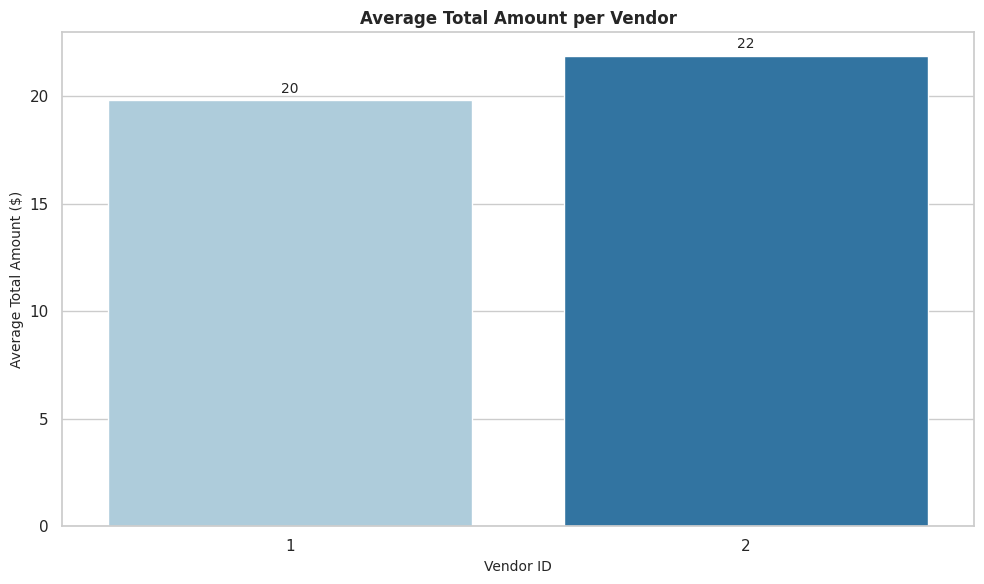

In [ ]:
fig, ax18 = plt.subplots(figsize=(10,6))

sns.barplot(x = 'VendorID', y = 'total_amount', data=df, estimator='mean', palette=color, ax=ax18, ci=None)
add_bar_labels(ax18)
ax18.set_title('Average Total Amount per Vendor', fontsize=12, fontweight='bold')
ax18.set_xlabel('Vendor ID', fontsize=10)
ax18.set_ylabel('Average Total Amount ($)', fontsize=10)

plt.tight_layout()
plt.show()

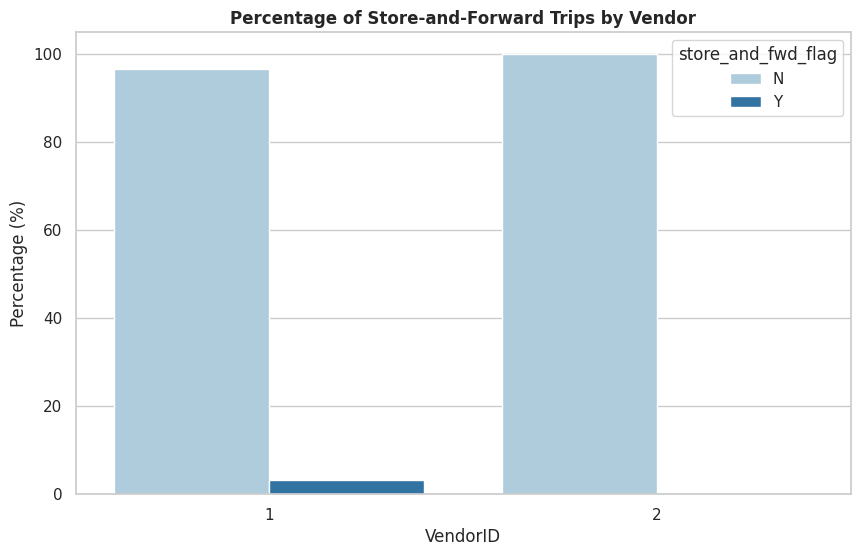

In [ ]:
plt.figure(figsize=(10,6))

store_counts = df.groupby(['VendorID','store_and_fwd_flag']).size().reset_index(name='count')
store_counts['total'] = store_counts.groupby('VendorID')['count'].transform('sum')
store_counts['percentage'] = (store_counts['count'] / store_counts['total']) * 100

sns.barplot(
    x='VendorID',
    y='percentage',
    hue='store_and_fwd_flag',
    data=store_counts,
    palette=color
)

plt.title("Percentage of Store-and-Forward Trips by Vendor", fontsize=12, fontweight='bold')
plt.ylabel("Percentage (%)")
plt.show()

Based on the graph, Vendor 1 (Creative Mobile Technologies, LLC.) has some trips that show store-and-forward delays (Y), although the ratio is quite small. Meanwhile, Vendor 2 (VeriFone Inc.) records are sent directly to the vendor in real time (N).

Text(0, 0.5, 'Number of Disputed Trips')

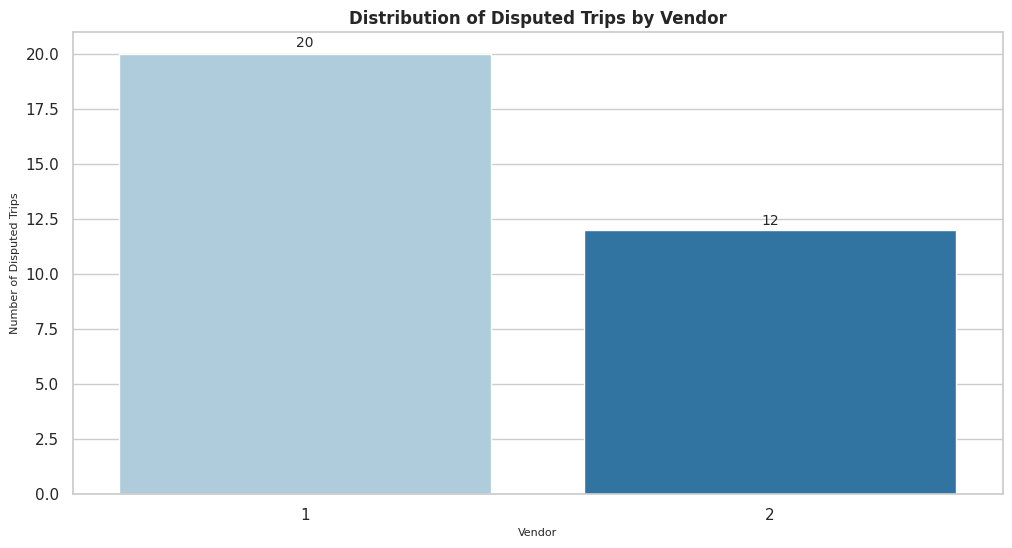

In [ ]:
dispute_trip = df[df['payment_type'] == 4]

fig, ax20 = plt.subplots(figsize=(12,6))

ax20 = sns.countplot(x = 'VendorID', data=dispute_trip , palette = color, ax=ax20)
add_bar_labels(ax20)
ax20.set_title('Distribution of Disputed Trips by Vendor', fontsize=12, fontweight='bold')
ax20.set_xlabel('Vendor', fontsize=8)
ax20.set_ylabel('Number of Disputed Trips', fontsize=8)

Vendor 1 (Creative Mobile Technologies, LLC.) recorded more disputed trips compared to Vendor 2 (VeriFone Inc.).

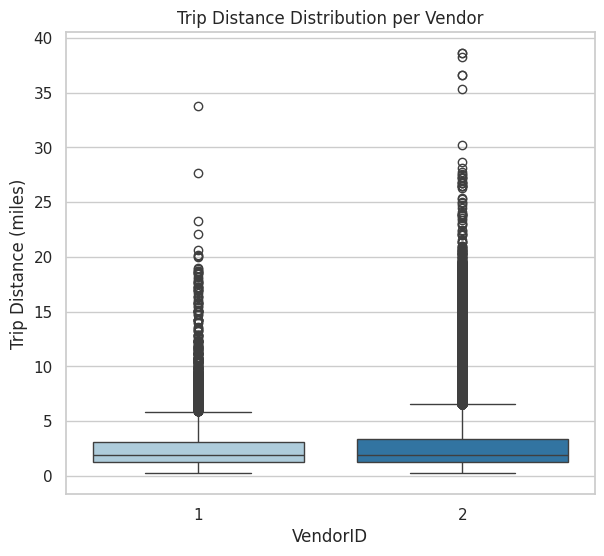

In [ ]:
plt.figure(figsize=(15,6))

# Trip Distance per Vendor
plt.subplot(1, 2, 1)
sns.boxplot(
    x="VendorID",
    y="trip_distance",
    data=df,
    palette=color
)
plt.title("Trip Distance Distribution per Vendor")
plt.ylabel("Trip Distance (miles)")
plt.xlabel("VendorID")
plt.show()

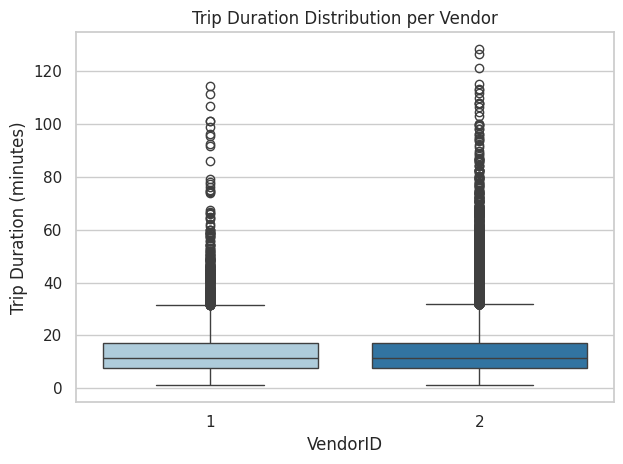

In [ ]:
sns.boxplot(
    x="VendorID",
    y="trip_duration_min",   # make sure you already created a duration column in minutes
    data=df,
    palette=color
)
plt.title("Trip Duration Distribution per Vendor")
plt.ylabel("Trip Duration (minutes)")
plt.xlabel("VendorID")

plt.tight_layout()
plt.show()

The boxplots of trip distance and trip duration across vendors reveal that the overall distribution patterns appear quite similar, with overlapping ranges and comparable median values. However, subtle differences exist in terms of spread and outliers. Vendor 2 shows a slightly wider spread of distances and tends to have longer trip durations, while Vendor 1’s trips are more tightly clustered around shorter distances but also exhibit relatively longer durations. This pattern may suggest that Vendor 2 is more frequently engaged in trips to areas with greater variability in demand, such as airports or outer-boroughs, whereas Vendor 1 appears more concentrated in trips with shorter distances

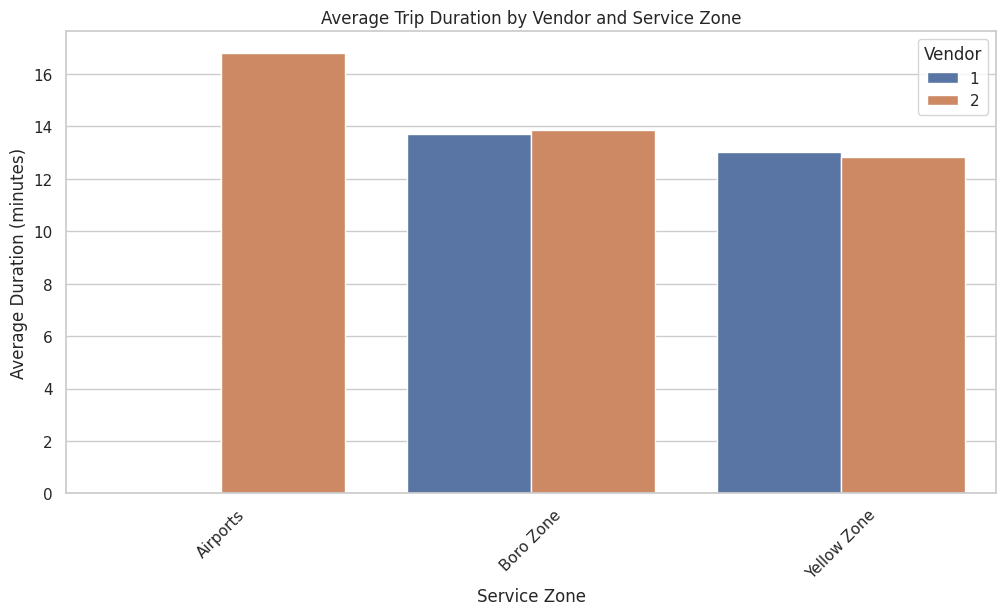

In [ ]:
avg_duration = df.groupby(["PU_service_zone", "VendorID"])["trip_duration_min"].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=avg_duration, x="PU_service_zone", y="trip_duration_min", hue="VendorID")
plt.title("Average Trip Duration by Vendor and Service Zone")
plt.xlabel("Service Zone")
plt.ylabel("Average Duration (minutes)")
plt.xticks(rotation=45)
plt.legend(title="Vendor")
plt.show()

The graph confirms the previous analysis: Vendor 2 recorded longer trip distances and durations because most of its trips are concentrated in the Airport service zone, followed by the Boro zone. In contrast, Vendor 1 has the majority of its trips in the Yellow zone, which typically involves shorter distances and durations within Manhattan.

# Conslusion & Recommendation

## Conslucsion

1. Trip Patterns - Taxi trips show a steady increase between 1 PM and 6 PM, with demand peaking at 6 PM, making this the strongest period. Among weekdays, Tuesday records the highest number of trips, followed by Thursday and Friday, driven by office, school, and after-work activities, while weekends have fewer trips overall. During night hours (1–5 AM), demand remains notable, but supply is much lower, creating pressure on the limited taxis available.
2. Area Distibution - Most taxi trips occur in Manhattan, driven by its concentration of businesses, attractions, and transport hubs, followed by Queens, Brooklyn, and Staten Island. East Harlem North and South dominate both pickups and drop-offs, with East Harlem South leading in drop-offs, indicating strong demand in residential and commercial areas. Brooklyn and Queens see more trips in the evening, often linked to commuting, airport travel, or nightlife, while the Bronx records higher morning trips, reflecting commuter patterns.
3. Pricing Patterns - Average fares are highest around 5 AM, when taxi supply is low but demand is still notable, creating upward pressure on prices. Tipping behavior peaks on Sundays, followed by Thursdays and Saturdays, with longer trips (such as on Sundays) and evening trips (such as on Thursdays) more likely to generate higher tips.
4. Congestion Patterns - The 2.75 congestion surcharge increases in the afternoon, starting around 1 PM and peaking at 6 PM, which matches heavy traffic hours. The 2.50 surcharge is highest around 12 PM, showing midday traffic pressure.
5. Vendor Performance - Vendor 2 (VeriFone Inc.) appears more reliable because it sends records in real time, earns more revenue, and has fewer disputed trips. Vendor 2 also handles more airport and outer-borough trips, which explains its longer trip distances and durations. Meanwhile, Vendor 1 (Creative Mobile Technologies, LLC.) is more concentrated in Manhattan’s Yellow Zone, with shorter trips, some store-and-forward delays, and a higher number of disputed trips.





## Recommendation

1. Taxi supply should be gradually increased between 1 PM and 6 PM on weekdays, especially in the afternoon, with the greatest focus on Tuesday when demand is highest. Extra supply is also needed in the evenings, particularly from Wednesday to Friday, to cover after-work and social activities. For night hours (1–5 AM), especially on weekends, more taxis should be deployed to reduce the supply–demand gap and provide better service for late-night passengers.
2. Encourage a higher allocation of taxis in Manhattan during the afternoon to handle business and tourist activity. In Brooklyn and Queens, more taxis should be directed to the evening period to support commuting, airport arrivals, and nightlife demand. For the Bronx, taxi availability should be increased during the morning to align with commuter travel patterns.
3. Keep an eye on early morning fares to make sure prices stay fair for riders. TLC can also share tipping trends with drivers, showing that Sundays and Thursday evenings are good times to work for higher tips. This can help drivers choose better shifts and improve service for passengers. In Addition, consider discount/flat fare pilots in Bronx, Staten Island, and EWR to stimulate demand where taxi use is low.
4. Apply stronger congestion surcharges in Manhattan during the morning and afternoon, especially around East Harlem and the Upper East Side, since these areas show high trip activity. In the evening, surcharges can also be considered in Queens and Brooklyn, while the Bronx may need adjustments in the morning. Using trip count as a proxy, TLC can better match surcharge timing and location to passenger activity and potential traffic build-up.
5. Encourage Vendor 1 to improve service quality by reducing disputed trips and minimizing store-and-forward delays. Vendor 1 should also expand coverage beyond Manhattan to handle longer trips while keeping strong performance in the Yellow Zone. Vendor 2’s reliable service and strong role in airport and outer-borough trips should be maintained and further supported, as this coverage is important for meeting demand in high-traffic and variable areas.

In [ ]:
filtered_df = df[(df['payment_type'] != 4) & (df['fare_amount'] > 0)]

# Simpan hasil ke CSV
output_path = "nyc_tlc_clean.csv"
filtered_df.to_csv(output_path, index=False)

print(f"File berhasil disimpan ke {output_path}")

File berhasil disimpan ke nyc_tlc_clean.csv
